### Import Major Libraries

In [17]:
import json
import requests
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

## Define Gameweek and Periods for FDR calculation

In [14]:
gameweek = 8
next_n_games = 2

#define percentage of time player needs to have played to be counted as active
min_min = ((gameweek-1)*90)/4     #<---- Currently 25% of playtime
print(min_min)

157.5


## Define Budget, Team Formation, and Budget Allocation by Position

In [4]:
#Budget
budget = 100

#Team Formation
DF = 3
MD = 4
ST = 3

#Total players needed per position
DF_max = 5
MD_max = 5
ST_max = 3

#Budget Allocation
GK_coef = 0.095
DF_coef = 0.285
MD_coef = 0.36
ST_coef = 0.26

print(sum([GK_coef, DF_coef, MD_coef, ST_coef]))

1.0


## Scraped list of Schedules

In [5]:
schedules = ['Arsenal NEW (A) BUR (H) LIV (A) TOT (H) WAT (A) AVL (H) MUN (A) BOU (H) SHU (A) CRY (H) WOL (H) LEI (A) SOU (H) NOR (A) BHA (H) WHU (A) MCI (H) EVE (A) BOU (A) CHE (H) MUN (H) CRY (A) SHU (H) CHE (A) BUR (A) NEW (H) EVE (H) MCI (A) WHU (H) BHA (A) SOU (A) NOR (H) WOL (A) LEI (H) TOT (A) LIV (H) AVL (A) WAT (H)',
 'Aston Villa TOT (A) BOU (H) EVE (H) CRY (A) WHU (H) ARS (A) BUR (H) NOR (A) BHA (H) MCI (A) LIV (H) WOL (A) NEW (H) MUN (A) CHE (A) LEI (H) SHU (A) SOU (H) NOR (H) WAT (A) BUR (A) MCI (H) BHA (A) WAT (H) BOU (A) TOT (H) SOU (A) SHU (H) LEI (A) CHE (H) NEW (A) WOL (H) LIV (A) MUN (H) CRY (H) EVE (A) ARS (H) WHU (A)',
 'Bournemouth SHU (H) AVL (A) MCI (H) LEI (A) EVE (H) SOU (A) WHU (H) ARS (A) NOR (H) WAT (A) MUN (H) NEW (A) WOL (H) TOT (A) CRY (A) LIV (H) CHE (A) BUR (H) ARS (H) BHA (A) WHU (A) WAT (H) NOR (A) BHA (H) AVL (H) SHU (A) BUR (A) CHE (H) LIV (A) CRY (H) WOL (A) NEW (H) MUN (A) TOT (H) LEI (H) MCI (A) SOU (H) EVE (A)',
 'Brighton WAT (A) WHU (H) SOU (H) MCI (A) BUR (H) NEW (A) CHE (A) TOT (H) AVL (A) EVE (H) NOR (H) MUN (A) LEI (H) LIV (A) ARS (A) WOL (H) CRY (A) SHU (H) TOT (A) BOU (H) CHE (H) EVE (A) AVL (H) BOU (A) WHU (A) WAT (H) SHU (A) CRY (H) WOL (A) ARS (H) LEI (A) MUN (H) NOR (A) LIV (H) MCI (H) SOU (A) NEW (H) BUR (A)',
 'Burnley SOU (H) ARS (A) WOL (A) LIV (H) BHA (A) NOR (H) AVL (A) EVE (H) LEI (A) CHE (H) SHU (A) WHU (H) WAT (A) CRY (H) MCI (H) TOT (A) NEW (H) BOU (A) EVE (A) MUN (H) AVL (H) CHE (A) LEI (H) MUN (A) ARS (H) SOU (A) BOU (H) NEW (A) TOT (H) MCI (A) WAT (H) CRY (A) SHU (H) WHU (A) LIV (A) WOL (H) NOR (A) BHA (H)',
 'Chelsea MUN (A) LEI (H) NOR (A) SHU (H) WOL (A) LIV (H) BHA (H) SOU (A) NEW (H) BUR (A) WAT (A) CRY (H) MCI (A) WHU (H) AVL (H) EVE (A) BOU (H) TOT (A) SOU (H) ARS (A) BHA (A) BUR (H) NEW (A) ARS (H) LEI (A) MUN (H) TOT (H) BOU (A) EVE (H) AVL (A) MCI (H) WHU (A) WAT (H) CRY (A) SHU (A) NOR (H) LIV (A) WOL (H)',
 'Crystal Palace EVE (H) SHU (A) MUN (A) AVL (H) TOT (A) WOL (H) NOR (H) WHU (A) MCI (H) ARS (A) LEI (H) CHE (A) LIV (H) BUR (A) BOU (H) WAT (A) BHA (H) NEW (A) WHU (H) SOU (A) NOR (A) ARS (H) MCI (A) SOU (H) SHU (H) EVE (A) NEW (H) BHA (A) WAT (H) BOU (A) LIV (A) BUR (H) LEI (A) CHE (H) AVL (A) MUN (H) WOL (A) TOT (H)',
 'Everton CRY (A) WAT (H) AVL (A) WOL (H) BOU (A) SHU (H) MCI (H) BUR (A) WHU (H) BHA (A) TOT (H) SOU (A) NOR (H) LEI (A) LIV (A) CHE (H) MUN (A) ARS (H) BUR (H) NEW (A) MCI (A) BHA (H) WHU (A) NEW (H) WAT (A) CRY (H) ARS (A) MUN (H) CHE (A) LIV (H) NOR (A) LEI (H) TOT (A) SOU (H) WOL (A) AVL (H) SHU (A) BOU (H)',
 'Leicester WOL (H) CHE (A) SHU (A) BOU (H) MUN (A) TOT (H) NEW (H) LIV (A) BUR (H) SOU (A) CRY (A) ARS (H) BHA (A) EVE (H) WAT (H) AVL (A) NOR (H) MCI (A) LIV (H) WHU (A) NEW (A) SOU (H) BUR (A) WHU (H) CHE (H) WOL (A) MCI (H) NOR (A) AVL (H) WAT (A) BHA (H) EVE (A) CRY (H) ARS (A) BOU (A) SHU (H) TOT (A) MUN (H)',
 'Liverpool NOR (H) SOU (A) ARS (H) BUR (A) NEW (H) CHE (A) SHU (A) LEI (H) MUN (A) TOT (H) AVL (A) MCI (H) CRY (A) BHA (H) EVE (H) BOU (A) WAT (H) WHU (A) LEI (A) WOL (H) SHU (H) TOT (A) MUN (H) WOL (A) SOU (H) NOR (A) WHU (H) WAT (A) BOU (H) EVE (A) CRY (H) MCI (A) AVL (H) BHA (A) BUR (H) ARS (A) CHE (H) NEW (A)',
 'Man City WHU (A) TOT (H) BOU (A) BHA (H) NOR (A) WAT (H) EVE (A) WOL (H) CRY (A) AVL (H) SOU (H) LIV (A) CHE (H) NEW (A) BUR (A) MUN (H) ARS (A) LEI (H) WOL (A) SHU (H) EVE (H) AVL (A) CRY (H) SHU (A) TOT (A) WHU (H) LEI (A) ARS (H) MUN (A) BUR (H) CHE (A) LIV (H) SOU (A) NEW (H) BHA (A) BOU (H) WAT (A) NOR (H)',
 'Man Utd CHE (H) WOL (A) CRY (H) SOU (A) LEI (H) WHU (A) ARS (H) NEW (A) LIV (H) NOR (A) BOU (A) BHA (H) SHU (A) AVL (H) TOT (H) MCI (A) EVE (H) WAT (A) NEW (H) BUR (A) ARS (A) NOR (H) LIV (A) BUR (H) WOL (H) CHE (A) WAT (H) EVE (A) MCI (H) TOT (A) SHU (H) BHA (A) BOU (H) AVL (A) SOU (H) CRY (A) WHU (H) LEI (A)',
 'Newcastle ARS (H) NOR (A) TOT (A) WAT (H) LIV (A) BHA (H) LEI (A) MUN (H) CHE (A) WOL (H) WHU (A) BOU (H) AVL (A) MCI (H) SHU (A) SOU (H) BUR (A) CRY (H) MUN (A) EVE (H) LEI (H) WOL (A) CHE (H) EVE (A) NOR (H) ARS (A) CRY (A) BUR (H) SOU (A) SHU (H) AVL (H) BOU (A) WHU (H) MCI (A) WAT (A) TOT (H) BHA (A) LIV (H)',
 'Norwich LIV (A) NEW (H) CHE (H) WHU (A) MCI (H) BUR (A) CRY (A) AVL (H) BOU (A) MUN (H) BHA (A) WAT (H) EVE (A) ARS (H) SOU (A) SHU (H) LEI (A) WOL (H) AVL (A) TOT (H) CRY (H) MUN (A) BOU (H) TOT (A) NEW (A) LIV (H) WOL (A) LEI (H) SHU (A) SOU (H) EVE (H) ARS (A) BHA (H) WAT (A) WHU (H) CHE (A) BUR (H) MCI (A)',
 'Sheffield Utd BOU (A) CRY (H) LEI (H) CHE (A) SOU (H) EVE (A) LIV (H) WAT (A) ARS (H) WHU (A) BUR (H) TOT (A) MUN (H) WOL (A) NEW (H) NOR (A) AVL (H) BHA (A) WAT (H) MCI (A) LIV (A) WHU (H) ARS (A) MCI (H) CRY (A) BOU (H) BHA (H) AVL (A) NOR (H) NEW (A) MUN (A) TOT (H) BUR (A) WOL (H) CHE (H) LEI (A) EVE (H) SOU (A)',
 'Southampton BUR (A) LIV (H) BHA (A) MUN (H) SHU (A) BOU (H) TOT (A) CHE (H) WOL (A) LEI (H) MCI (A) EVE (H) ARS (A) WAT (H) NOR (H) NEW (A) WHU (H) AVL (A) CHE (A) CRY (H) TOT (H) LEI (A) WOL (H) CRY (A) LIV (A) BUR (H) AVL (H) WHU (A) NEW (H) NOR (A) ARS (H) WAT (A) MCI (H) EVE (A) MUN (A) BHA (H) BOU (A) SHU (H)',
 'Spurs AVL (H) MCI (A) NEW (H) ARS (A) CRY (H) LEI (A) SOU (H) BHA (A) WAT (H) LIV (A) EVE (A) SHU (H) WHU (A) BOU (H) MUN (A) BUR (H) WOL (A) CHE (H) BHA (H) NOR (A) SOU (A) LIV (H) WAT (A) NOR (H) MCI (H) AVL (A) CHE (A) WOL (H) BUR (A) MUN (H) WHU (H) SHU (A) EVE (H) BOU (A) ARS (H) NEW (A) LEI (H) CRY (A)',
 'Watford BHA (H) EVE (A) WHU (H) NEW (A) ARS (H) MCI (A) WOL (A) SHU (H) TOT (A) BOU (H) CHE (H) NOR (A) BUR (H) SOU (A) LEI (A) CRY (H) LIV (A) MUN (H) SHU (A) AVL (H) WOL (H) BOU (A) TOT (H) AVL (A) EVE (H) BHA (A) MUN (A) LIV (H) CRY (A) LEI (H) BUR (A) SOU (H) CHE (A) NOR (H) NEW (H) WHU (A) MCI (H) ARS (A)',
 'West Ham MCI (H) BHA (A) WAT (A) NOR (H) AVL (A) MUN (H) BOU (A) CRY (H) EVE (A) SHU (H) NEW (H) BUR (A) TOT (H) CHE (A) WOL (A) ARS (H) SOU (A) LIV (H) CRY (A) LEI (H) BOU (H) SHU (A) EVE (H) LEI (A) BHA (H) MCI (A) LIV (A) SOU (H) ARS (A) WOL (H) TOT (A) CHE (H) NEW (A) BUR (H) NOR (A) WAT (H) MUN (A) AVL (H)',
 'Wolves LEI (A) MUN (H) BUR (H) EVE (A) CHE (H) CRY (A) WAT (H) MCI (A) SOU (H) NEW (A) ARS (A) AVL (H) BOU (A) SHU (H) WHU (H) BHA (A) TOT (H) NOR (A) MCI (H) LIV (A) WAT (A) NEW (H) SOU (A) LIV (H) MUN (A) LEI (H) NOR (H) TOT (A) BHA (H) WHU (A) BOU (H) AVL (A) ARS (H) SHU (A) EVE (H) BUR (A) CRY (H) CHE (A)']

### Import Data

In [6]:


# url = "https://fantasy.premierleague.com/drf/bootstrap-static"
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'

def get_json_data(url):
    response = requests.get(url)
    jobs = response.json()
    return jobs

#filter out players with less than 330
all_players = get_json_data(url)['elements']
all_teams = get_json_data(url)['teams']
positions = get_json_data(url)['element_types']

### Get Team Table

In [2]:
table_url = 'https://www.premierleague.com/tables'

def build_table(table_url):
    team_table = pd.read_html(table_url)
    team_df = pd.DataFrame(team_table[0])
    team_df = team_df[team_df['Unnamed: 12'].isna()]
    team_df = team_df.iloc[:,1:10]
    team_df.Club = team_df.Club.map(lambda x: x[-3:])
    team_df.reset_index()
    team_df.index = np.arange(1, len(team_df) + 1)
    team_df.columns = ['Team', 'Played', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']
    team_df.index.name = 'Position'
    
    return team_df

In [3]:
table_url = 'https://www.premierleague.com/tables'
team_table = pd.read_html(table_url)
team_table[0]

Position  Pos  \
0                             1  Previous Position  1   
1   Liverpool  Recent Result - Saturday 5 October ...   
2                             2  Previous Position  2   
3   Manchester City  Recent Result - Sunday 6 Octo...   
4                             3  Previous Position  4   
5   Arsenal  Recent Result - Sunday 6 October 2019...   
6                             4  Previous Position  3   
7   Leicester City  Recent Result - Saturday 5 Oct...   
8                             5  Previous Position  7   
9   Chelsea  Recent Result - Sunday 6 October 2019...   
10                            6  Previous Position  9   
11  Crystal Palace  Recent Result - Saturday 5 Oct...   
12                           7  Previous Position  11   
13  Burnley  Recent Result - Saturday 5 October 20...   
14                            8  Previous Position  5   
15  West Ham United  Recent Result - Saturday 5 Oc...   
16                            9  Previous Position  6   
17  Tottenham Hotspur  Recent Result - Saturday 5 ...   
18                           10  Previous Position  8   
19  Bournemouth  Recent Result - Sunday 6 October ...   
20                          11  Previous Position  13   
21  Wolverhampton Wanderers  Recent Result - Sunda...   
22                          12  Previous Position  10   
23  Manchester United  Recent Result - Sunday 6 Oc...   
24                          13  Previous Position  12   
25  Sheffield United  Recent Result - Saturday 5 O...   
26                          14  Previous Position  16   
27  Brighton and Hove Albion  Recent Result - Satu...   
28                          15  Previous Position  18   
29  Aston Villa  Recent Result - Saturday 5 Octobe...   
30                          16  Previous Position  19   
31  Newcastle United  Recent Result - Sunday 6 Oct...   
32                          17  Previous Position  14   
33  Southampton  Recent Result - Sunday 6 October ...   
34                          18  Previous Position  15   
35  Everton  Recent Result - Saturday 5 October 20...   
36                          19  Previous Position  17   
37  Norwich City  Recent Result - Saturday 5 Octob...   
38                          20  Previous Position  20   
39  Watford  Recent Result - Saturday 5 October 20...   

                                                 Club  \
0                                        LiverpoolLIV   
1   Liverpool  Recent Result - Saturday 5 October ...   
2                                  Manchester CityMCI   
3   Manchester City  Recent Result - Sunday 6 Octo...   
4                                          ArsenalARS   
5   Arsenal  Recent Result - Sunday 6 October 2019...   
6                                   Leicester CityLEI   
7   Leicester City  Recent Result - Saturday 5 Oct...   
8                                          ChelseaCHE   
9   Chelsea  Recent Result - Sunday 6 October 2019...   
10                                  Crystal PalaceCRY   
11  Crystal Palace  Recent Result - Saturday 5 Oct...   
12                                         BurnleyBUR   
13  Burnley  Recent Result - Saturday 5 October 20...   
14                                 West Ham UnitedWHU   
15  West Ham United  Recent Result - Saturday 5 Oc...   
16                               Tottenham HotspurTOT   
17  Tottenham Hotspur  Recent Result - Saturday 5 ...   
18                                     BournemouthBOU   
19  Bournemouth  Recent Result - Sunday 6 October ...   
20                         Wolverhampton WanderersWOL   
21  Wolverhampton Wanderers  Recent Result - Sunda...   
22                               Manchester UnitedMUN   
23  Manchester United  Recent Result - Sunday 6 Oc...   
24                                Sheffield UnitedSHU   
25  Sheffield United  Recent Result - Saturday 5 O...   
26                        Brighton and Hove AlbionBHA   
27  Brighton and Hove Albion  Recent Result - Satu...   
28                                     Aston Vill

In [4]:
table_df = build_table(table_url)

In [5]:
table_df.head()

Team Played  W  D  L  GF  GA   GD Pts
Position                                      
1         LIV      8  8  0  0  20   6  +14  24
2         MCI      8  5  1  2  27   9  +18  16
3         ARS      8  4  3  1  13  11   +2  15
4         LEI      8  4  2  2  14   7   +7  14
5         CHE      8  4  2  2  18  14   +4  14

### Try dynamic FDR Score

In [6]:
#List of teams
name_list = list(table_df.Team)

#list of points as integers
pts_list = [int(item) for item in table_df.Pts]
top_pts = max(pts_list)

#list of GF as integers
GF_list = [int(item) for item in table_df.GF]
top_GF = max(GF_list)

#list of GA as integers
GA_list = [int(item) for item in table_df.GA]
top_GA = max(GA_list)

In [7]:
top_pts, top_GF, top_GA

(24, 27, 21)

In [8]:
name_list[:5]

['LIV', 'MCI', 'ARS', 'LEI', 'CHE']

In [9]:
from scipy import stats
stats.percentileofscore(GF_list, 20)

95.0

In [10]:
zipped_list = list(zip(name_list, pts_list, GF_list, GA_list))

In [11]:
zipped_list[:3]

[('LIV', 24, 20, 6), ('MCI', 16, 27, 9), ('ARS', 15, 13, 11)]

In [12]:
def get_percentiles(zipped_list):
    listy = []
    for item in zipped_list:
        team = item[0]
        pts_perc = stats.percentileofscore(pts_list, item[1])
        GF_perc = stats.percentileofscore(GF_list, item[2])
        GA_perc = stats.percentileofscore(GA_list, item[3])
        FDR = pts_perc + GF_perc + (100-GA_perc)
        tup = (team, FDR)
        listy.append(tup)
    return listy
    

In [13]:
FDR_new = get_percentiles(zipped_list)

In [14]:
FDR_new

[('LIV', 290.0),
 ('MCI', 262.5),
 ('ARS', 210.0),
 ('LEI', 250.0),
 ('CHE', 185.0),
 ('CRY', 187.5),
 ('BUR', 190.0),
 ('WHU', 172.5),
 ('TOT', 177.5),
 ('BOU', 152.5),
 ('WOL', 155.0),
 ('MUN', 157.5),
 ('SHU', 147.5),
 ('BHA', 130.0),
 ('AVL', 135.0),
 ('NEW', 62.5),
 ('SOU', 57.5),
 ('EVE', 57.5),
 ('NOR', 55.0),
 ('WAT', 15.0)]

In [19]:
mean_FDR = np.mean([item[1] for item in FDR_new])

In [20]:
mean_FDR

152.5

<function matplotlib.pyplot.show(*args, **kw)>

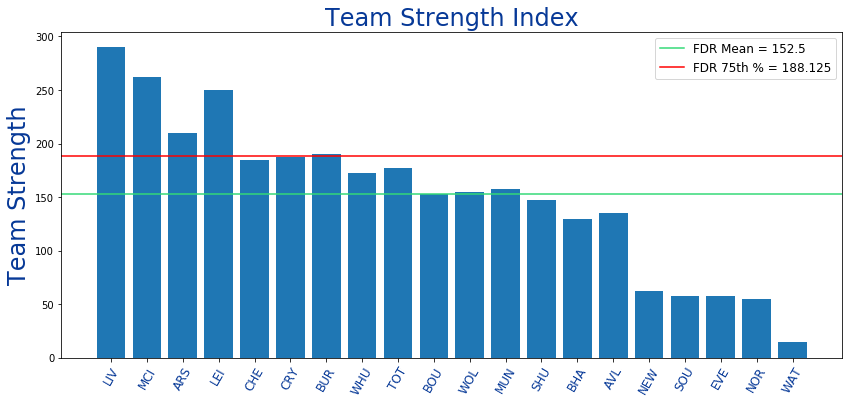

In [26]:
Team = [item[0] for item in FDR_new]
strength = [item[1] for item in FDR_new]

mean_FDR = np.mean([item[1] for item in FDR_new])
FDR_75 = np.percentile([item[1] for item in FDR_new], 75)

plt.bar(Team, strength)
plt.axhline(y=mean_FDR, linestyle='-', color='#33D977', label='FDR Mean = ' + str(mean_FDR))
plt.axhline(y=FDR_75, linestyle='-', color='red', label='FDR 75th % = ' + str(FDR_75))
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Team Strength Index', fontsize = 24, color = '#073997')
plt.legend(fontsize = '12')
plt.show

### Function to return percentile for each team

## Add player status and ROI, pts-per-90min metrics to final player_df

In [11]:
def attach_team_and_position(main_players, all_teams, positons):
    players = main_players.copy()
    for team in all_teams:
        for player in players:
            if team['code'] == player['team_code']:
                player['team_name'] = team['name']
    for position in positions:
        for player in players:
            if position['id'] == player['element_type']:
                player['position'] = position['singular_name']
    for player in players:
        if player['status'] == "a":
            player['status'] = "available"
        elif player['status'] == "d":
            player['status'] = "doubtful"
        elif player['status'] == "i":
            player['status'] = "injured"
        elif player['status'] == "s":
            player['status'] = "suspended"
    return players


#### Temporarily took out the "main_players" filter because no players have played 330 minutes ####

# player_positions_teams = attach_team_and_position(main_players, all_teams_new, positions)
player_positions_teams = attach_team_and_position(all_players, all_teams, positions)


def final_players_list(player_positions_teams):
    players = player_positions_teams.copy()
    empty = []
    for player in players:
        stats = dict(team_code = player['team_code'],
        team_name = player['team_name'],
        name = player['first_name'] + " " + player['second_name'],
        status = player['status'],
        position = player['position'],
        cost = (player['now_cost'])/10,
        total_points = player['total_points'],
        roi = round((player['total_points'] / player['now_cost'])*10, 2),
        pts_per_90min = round((player['total_points'] / (player['minutes'] + 1))*90, 2),
        bonus = player['bonus'],
        red_cards = player['red_cards'],
        minutes = player['minutes'],
        transfers_out = player['transfers_out'],
        transfers_in = player['transfers_in'])
        empty.append(stats)
    return empty

In [12]:
final = final_players_list(player_positions_teams)

In [13]:
final[0]

{'team_code': 3,
 'team_name': 'Arsenal',
 'name': 'Shkodran Mustafi',
 'status': 'available',
 'position': 'Defender',
 'cost': 5.3,
 'total_points': 0,
 'roi': 0.0,
 'pts_per_90min': 0.0,
 'bonus': 0,
 'red_cards': 0,
 'minutes': 0,
 'transfers_out': 26899,
 'transfers_in': 5688}

In [14]:
all_teams[0]

{'code': 3,
 'draw': 0,
 'form': None,
 'id': 1,
 'loss': 0,
 'name': 'Arsenal',
 'played': 0,
 'points': 0,
 'position': 0,
 'short_name': 'ARS',
 'strength': 4,
 'team_division': None,
 'unavailable': False,
 'win': 0,
 'strength_overall_home': 1250,
 'strength_overall_away': 1330,
 'strength_attack_home': 1210,
 'strength_attack_away': 1260,
 'strength_defence_home': 1290,
 'strength_defence_away': 1330}

### Get Total ROI, Points and 90min before filtering injured and FDR

In [15]:
total_roi = sorted(final, key = lambda x: x['roi'], reverse = True)

In [16]:
total_roi[:2]

[{'team_code': 49,
  'team_name': 'Sheffield Utd',
  'name': 'John Lundstram',
  'status': 'available',
  'position': 'Defender',
  'cost': 4.5,
  'total_points': 39,
  'roi': 8.67,
  'pts_per_90min': 5.09,
  'bonus': 7,
  'red_cards': 0,
  'minutes': 688,
  'transfers_out': 216049,
  'transfers_in': 1736854},
 {'team_code': 36,
  'team_name': 'Brighton',
  'name': 'Mathew Ryan',
  'status': 'available',
  'position': 'Goalkeeper',
  'cost': 4.6,
  'total_points': 35,
  'roi': 7.61,
  'pts_per_90min': 4.37,
  'bonus': 6,
  'red_cards': 0,
  'minutes': 720,
  'transfers_out': 337548,
  'transfers_in': 421255}]

### Total_Points

In [17]:
total_max_pts = sorted(total_roi, key = lambda x: x['total_points'], reverse = True)

In [18]:
total_max_pts[:2]

[{'team_code': 43,
  'team_name': 'Man City',
  'name': 'Kevin De Bruyne',
  'status': 'doubtful',
  'position': 'Midfielder',
  'cost': 10.0,
  'total_points': 63,
  'roi': 6.3,
  'pts_per_90min': 10.72,
  'bonus': 10,
  'red_cards': 0,
  'minutes': 528,
  'transfers_out': 1272957,
  'transfers_in': 2138865},
 {'team_code': 43,
  'team_name': 'Man City',
  'name': 'Sergio Agüero',
  'status': 'available',
  'position': 'Forward',
  'cost': 12.2,
  'total_points': 61,
  'roi': 5.0,
  'pts_per_90min': 9.79,
  'bonus': 6,
  'red_cards': 0,
  'minutes': 560,
  'transfers_out': 492953,
  'transfers_in': 1167690}]

### 90 min

In [19]:
total_90min = sorted(total_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
total_90min = [player for player in total_90min if player['minutes'] >= min_min]

In [20]:
total_90min[:2]

[{'team_code': 43,
  'team_name': 'Man City',
  'name': 'Kevin De Bruyne',
  'status': 'doubtful',
  'position': 'Midfielder',
  'cost': 10.0,
  'total_points': 63,
  'roi': 6.3,
  'pts_per_90min': 10.72,
  'bonus': 10,
  'red_cards': 0,
  'minutes': 528,
  'transfers_out': 1272957,
  'transfers_in': 2138865},
 {'team_code': 43,
  'team_name': 'Man City',
  'name': 'Sergio Agüero',
  'status': 'available',
  'position': 'Forward',
  'cost': 12.2,
  'total_points': 61,
  'roi': 5.0,
  'pts_per_90min': 9.79,
  'bonus': 6,
  'red_cards': 0,
  'minutes': 560,
  'transfers_out': 492953,
  'transfers_in': 1167690}]

### Create Players DataFrame

In [21]:
player_df = pd.DataFrame(final)

In [22]:
player_df.sort_values(by = ['roi'], ascending = False, inplace = True)

In [23]:
player_df.head(10)

bonus  cost  minutes                           name    position  \
390      7   4.5      688                 John Lundstram    Defender   
96       6   4.6      720                    Mathew Ryan  Goalkeeper   
361      9   7.1      705                    Teemu Pukki     Forward   
538      4   5.1      720  Rui Pedro dos Santos Patrício  Goalkeeper   
403      2   4.5      720                 Dean Henderson  Goalkeeper   
91       7   4.6      720                     Lewis Dunk    Defender   
137      5   4.8      684                   Erik Pieters    Defender   
173      2   4.1      528                   Martin Kelly    Defender   
160     11   7.7      569                  Tammy Abraham     Forward   
126      2   4.6      720                      Nick Pope  Goalkeeper   

     pts_per_90min  red_cards   roi     status  team_code       team_name  \
390           5.09          0  8.67  available         49   Sheffield Utd   
96            4.37          0  7.61  available         36        Brighton   
361           6.88          0  7.61  available         45         Norwich   
538           4.74          0  7.45  available         39          Wolves   
403           4.12          0  7.33  available         49   Sheffield Utd   
91            4.12          0  7.17  available         36        Brighton   
137           4.47          0  7.08   doubtful         90         Burnley   
173           4.93          0  7.07  available         31  Crystal Palace   
160           8.53          0  7.01  available          8         Chelsea   
126           3.99          0  6.96  available         90         Burnley   

     total_points  transfers_in  transfers_out  
390            39       1736854         216049  
96             35        421255         337548  
361            54       3164050         897411  
538            38        477028         220992  
403            33        170592          56480  
91             33        504885         311510  
137            34        926505         259988  
173            29        762255         569753  
160            54       2858820         360069  
126            32        755173         197588

### Merge two team tables s owe have all data

In [24]:
def merged_teams(table_df, all_teams):
    table_dic = table_df.to_dict('records')
    
    for team in table_dic:
        for item in all_teams:
            if team['Team'] == item['short_name']:
                team['code'] = item['code']
                team['name'] = item['name']
                team['strength'] = item['strength']
            
    new_df = pd.DataFrame(table_dic)
    
    new_order = ['code', 'strength', 'Team','name', 'Played', 'W', 'L', 'D', 'GF', 'GA', 'GD', 'Pts']
    
    table_df = new_df[new_order]
    
    table_df.index = np.arange(1, len(table_df) + 1)
    table_df.index.name = 'Position'
    
    return table_df
    

In [25]:
team_df = merged_teams(table_df, all_teams)

In [26]:
team_df.head()

code  strength Team       name Played  W  L  D  GF  GA   GD Pts
Position                                                                 
1           14         5  LIV  Liverpool      8  8  0  0  20   6  +14  24
2           43         5  MCI   Man City      8  5  2  1  27   9  +18  16
3            3         4  ARS    Arsenal      8  4  1  3  13  11   +2  15
4           13         3  LEI  Leicester      8  4  2  2  14   7   +7  14
5            8         4  CHE    Chelsea      8  4  2  2  18  14   +4  14

In [27]:
team_names = list(team_df.name)

In [28]:
team_names.sort()

In [29]:
team_names

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man Utd',
 'Newcastle',
 'Norwich',
 'Sheffield Utd',
 'Southampton',
 'Spurs',
 'Watford',
 'West Ham',
 'Wolves']

## Create Schedule DF

In [30]:
def extract_sched(schedules):
    dic = {}
    for i, item in enumerate(schedules):
        name = item.partition(team_names[i])[1]
        sche = item.partition(team_names[i])[2]
        sche = sche.split()
        clean = [item for item in sche if item != "(A)"]
        clean2 = [item for item in clean if item != "(H)"]
        dic[name] = clean2
    return dic

In [31]:
wonders = extract_sched(schedules)

In [32]:
schedule_df = pd.DataFrame(wonders)

In [33]:
schedule_df.index.name = 'Gameweek'

In [34]:
schedule_df.head()

Arsenal Aston Villa Bournemouth Brighton Burnley Chelsea  \
Gameweek                                                            
0            NEW         TOT         SHU      WAT     SOU     MUN   
1            BUR         BOU         AVL      WHU     ARS     LEI   
2            LIV         EVE         MCI      SOU     WOL     NOR   
3            TOT         CRY         LEI      MCI     LIV     SHU   
4            WAT         WHU         EVE      BUR     BHA     WOL   

         Crystal Palace Everton Leicester Liverpool Man City Man Utd  \
Gameweek                                                               
0                   EVE     CRY       WOL       NOR      WHU     CHE   
1                   SHU     WAT       CHE       SOU      TOT     WOL   
2                   MUN     AVL       SHU       ARS      BOU     CRY   
3                   AVL     WOL       BOU       BUR      BHA     SOU   
4                   TOT     BOU       MUN       NEW      NOR     LEI   

         Newcastle Norwich Sheffield Utd Southampton Spurs Watford West Ham  \
Gameweek                                                                      
0              ARS     LIV           BOU         BUR   AVL     BHA      MCI   
1              NOR     NEW           CRY         LIV   MCI     EVE      BHA   
2              TOT     CHE           LEI         BHA   NEW     WHU      WAT   
3              WAT     WHU           CHE         MUN   ARS     NEW      NOR   
4              LIV     MCI           SOU         SHU   CRY     ARS      AVL   

         Wolves  
Gameweek         
0           LEI  
1           MUN  
2           BUR  
3           EVE  
4           CHE

In [35]:
schedule_df.Arsenal[0:3]

Gameweek
0    NEW
1    BUR
2    LIV
Name: Arsenal, dtype: object

## Create FDR scores for calculating next-n opponents AVG strength

In [36]:
scores = list(zip(team_df.Team, team_df.strength))

In [37]:
scores = dict(scores)

In [38]:
sorted(scores.items(), key = lambda x: x[1], reverse = True)

[('LIV', 5),
 ('MCI', 5),
 ('ARS', 4),
 ('CHE', 4),
 ('TOT', 4),
 ('MUN', 4),
 ('LEI', 3),
 ('CRY', 3),
 ('BUR', 3),
 ('WHU', 3),
 ('BOU', 3),
 ('WOL', 3),
 ('NEW', 3),
 ('SOU', 3),
 ('EVE', 3),
 ('NOR', 3),
 ('SHU', 2),
 ('BHA', 2),
 ('AVL', 2),
 ('WAT', 2)]

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

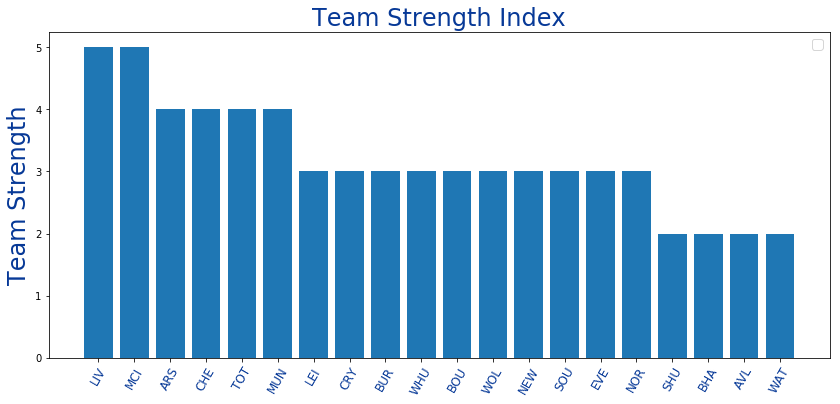

In [39]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# from pylab import rcParams
# rcParams['figure.figsize'] = 14, 6

sorted_data = sorted(scores.items(), key = lambda x: x[1], reverse = True)

Team = [item[0] for item in sorted_data]
strength = [item[1] for item in sorted_data]

plt.bar(Team, strength)
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Team Strength Index', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [40]:
schedule_df.columns

Index(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brighton', 'Burnley',
       'Chelsea', 'Crystal Palace', 'Everton', 'Leicester', 'Liverpool',
       'Man City', 'Man Utd', 'Newcastle', 'Norwich', 'Sheffield Utd',
       'Southampton', 'Spurs', 'Watford', 'West Ham', 'Wolves'],
      dtype='object')

In [41]:
schedule_df.head(10)

Arsenal Aston Villa Bournemouth Brighton Burnley Chelsea  \
Gameweek                                                            
0            NEW         TOT         SHU      WAT     SOU     MUN   
1            BUR         BOU         AVL      WHU     ARS     LEI   
2            LIV         EVE         MCI      SOU     WOL     NOR   
3            TOT         CRY         LEI      MCI     LIV     SHU   
4            WAT         WHU         EVE      BUR     BHA     WOL   
5            AVL         ARS         SOU      NEW     NOR     LIV   
6            MUN         BUR         WHU      CHE     AVL     BHA   
7            BOU         NOR         ARS      TOT     EVE     SOU   
8            SHU         BHA         NOR      AVL     LEI     NEW   
9            CRY         MCI         WAT      EVE     CHE     BUR   

         Crystal Palace Everton Leicester Liverpool Man City Man Utd  \
Gameweek                                                               
0                   EVE     CRY       WOL       NOR      WHU     CHE   
1                   SHU     WAT       CHE       SOU      TOT     WOL   
2                   MUN     AVL       SHU       ARS      BOU     CRY   
3                   AVL     WOL       BOU       BUR      BHA     SOU   
4                   TOT     BOU       MUN       NEW      NOR     LEI   
5                   WOL     SHU       TOT       CHE      WAT     WHU   
6                   NOR     MCI       NEW       SHU      EVE     ARS   
7                   WHU     BUR       LIV       LEI      WOL     NEW   
8                   MCI     WHU       BUR       MUN      CRY     LIV   
9                   ARS     BHA       SOU       TOT      AVL     NOR   

         Newcastle Norwich Sheffield Utd Southampton Spurs Watford West Ham  \
Gameweek                                                                      
0              ARS     LIV           BOU         BUR   AVL     BHA      MCI   
1              NOR     NEW           CRY         LIV   MCI     EVE      BHA   
2              TOT     CHE           LEI         BHA   NEW     WHU      WAT   
3              WAT     WHU           CHE         MUN   ARS     NEW      NOR   
4              LIV     MCI           SOU         SHU   CRY     ARS      AVL   
5              BHA     BUR           EVE         BOU   LEI     MCI      MUN   
6              LEI     CRY           LIV         TOT   SOU     WOL      BOU   
7              MUN     AVL           WAT         CHE   BHA     SHU      CRY   
8              CHE     BOU           ARS         WOL   WAT     TOT      EVE   
9              WOL     MUN           WHU         LEI   LIV     BOU      SHU   

         Wolves  
Gameweek         
0           LEI  
1           MUN  
2           BUR  
3           EVE  
4           CHE  
5           CRY  
6           WAT  
7           MCI  
8           SOU  
9           NEW

In [42]:
def avg_FDR(week = gameweek, periods = next_n_games):
    dic = {}
    for team in schedule_df.columns:
        oponents = schedule_df[team][(week-1):(week+periods)]
        avg_FDR = round(sum([scores[oponent] for oponent in oponents])/len(oponents), 2)
        dic[team] = avg_FDR
    return dic

In [43]:
calculate_FDR = avg_FDR()

In [44]:
sorted_FDR = sorted(calculate_FDR.items(), key=lambda x: x[1], reverse=True)

In [45]:
sorted_FDR

[('Crystal Palace', 4.0),
 ('Leicester', 3.67),
 ('Liverpool', 3.67),
 ('Man Utd', 3.67),
 ('Newcastle', 3.67),
 ('Wolves', 3.67),
 ('Aston Villa', 3.33),
 ('Burnley', 3.33),
 ('Southampton', 3.33),
 ('Bournemouth', 3.0),
 ('Brighton', 3.0),
 ('Chelsea', 3.0),
 ('Norwich', 3.0),
 ('Sheffield Utd', 3.0),
 ('Spurs', 3.0),
 ('Watford', 3.0),
 ('Arsenal', 2.67),
 ('Everton', 2.67),
 ('Man City', 2.67),
 ('West Ham', 2.67)]

<function matplotlib.pyplot.show(*args, **kw)>

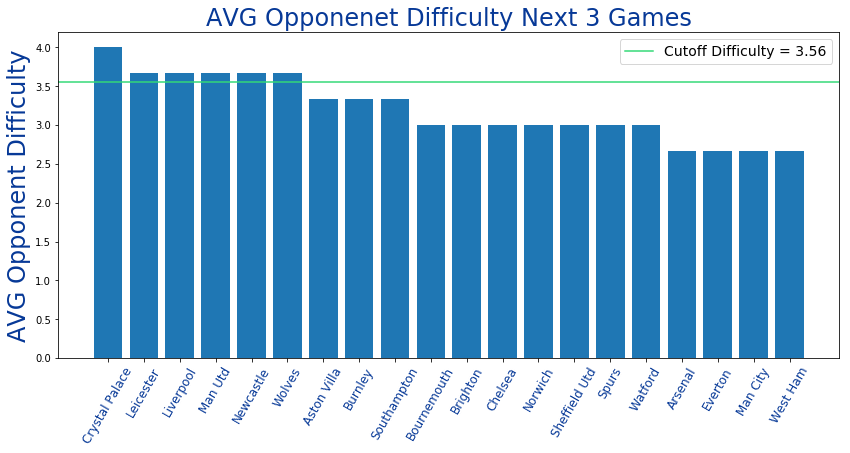

In [46]:
rcParams['figure.figsize'] = 14, 6

Team = [item[0] for item in sorted_FDR]
FDR = [item[1] for item in sorted_FDR]
cutoff = 3.56

plt.bar(Team, FDR)
plt.axhline(y=cutoff, linestyle='-', color='#33D977', label='Cutoff Difficulty = ' + str(cutoff))
plt.ylabel('AVG Opponent Difficulty', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('AVG Opponenet Difficulty Next ' + str(next_n_games +1) + ' Games', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Clean final list of available players by FDR score <= 3.56 and status = 'available'

In [47]:
player_df.head()

bonus  cost  minutes                           name    position  \
390      7   4.5      688                 John Lundstram    Defender   
96       6   4.6      720                    Mathew Ryan  Goalkeeper   
361      9   7.1      705                    Teemu Pukki     Forward   
538      4   5.1      720  Rui Pedro dos Santos Patrício  Goalkeeper   
403      2   4.5      720                 Dean Henderson  Goalkeeper   

     pts_per_90min  red_cards   roi     status  team_code      team_name  \
390           5.09          0  8.67  available         49  Sheffield Utd   
96            4.37          0  7.61  available         36       Brighton   
361           6.88          0  7.61  available         45        Norwich   
538           4.74          0  7.45  available         39         Wolves   
403           4.12          0  7.33  available         49  Sheffield Utd   

     total_points  transfers_in  transfers_out  
390            39       1736854         216049  
96             35        421255         337548  
361            54       3164050         897411  
538            38        477028         220992  
403            33        170592          56480

In [48]:
player_df.shape

(551, 14)

In [49]:
clean_df = player_df[player_df.status == 'available']

In [50]:
clean_df.status.value_counts()

available    411
Name: status, dtype: int64

## Remove teams with FDR scores > 3.56 from DF - optional

In [51]:
teams_low_FDR = [key for (key,value) in calculate_FDR.items() if value <= 3.56]

In [52]:
teams_low_FDR

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Chelsea',
 'Everton',
 'Man City',
 'Norwich',
 'Sheffield Utd',
 'Southampton',
 'Spurs',
 'Watford',
 'West Ham']

In [53]:
clean_df.head()

bonus  cost  minutes                           name    position  \
390      7   4.5      688                 John Lundstram    Defender   
96       6   4.6      720                    Mathew Ryan  Goalkeeper   
361      9   7.1      705                    Teemu Pukki     Forward   
538      4   5.1      720  Rui Pedro dos Santos Patrício  Goalkeeper   
403      2   4.5      720                 Dean Henderson  Goalkeeper   

     pts_per_90min  red_cards   roi     status  team_code      team_name  \
390           5.09          0  8.67  available         49  Sheffield Utd   
96            4.37          0  7.61  available         36       Brighton   
361           6.88          0  7.61  available         45        Norwich   
538           4.74          0  7.45  available         39         Wolves   
403           4.12          0  7.33  available         49  Sheffield Utd   

     total_points  transfers_in  transfers_out  
390            39       1736854         216049  
96             35        421255         337548  
361            54       3164050         897411  
538            38        477028         220992  
403            33        170592          56480

In [54]:
final_df = clean_df.loc[clean_df.team_name.isin(teams_low_FDR)]

In [55]:
final_df.head(15)

bonus  cost  minutes            name    position  pts_per_90min  \
390      7   4.5      688  John Lundstram    Defender           5.09   
96       6   4.6      720     Mathew Ryan  Goalkeeper           4.37   
361      9   7.1      705     Teemu Pukki     Forward           6.88   
403      2   4.5      720  Dean Henderson  Goalkeeper           4.12   
91       7   4.6      720      Lewis Dunk    Defender           4.12   
160     11   7.7      569   Tammy Abraham     Forward           8.53   
126      2   4.6      720       Nick Pope  Goalkeeper           3.99   
163      6   6.8      709     Mason Mount  Midfielder           5.83   
370      2   4.9      685   Todd Cantwell  Midfielder           4.33   
39       4   5.8      720     John McGinn  Midfielder           4.87   
47       7   6.0      694   Wesley Moraes     Forward           5.18   
387      3   4.5      720  George Baldock    Defender           3.74   
384      4   5.0      720    Enda Stevens    Defender           4.12   
118      0   4.5      720  Matthew Lowton    Defender           3.50   
38       0   5.5      484  Anwar El Ghazi  Midfielder           6.31   

     red_cards   roi     status  team_code      team_name  total_points  \
390          0  8.67  available         49  Sheffield Utd            39   
96           0  7.61  available         36       Brighton            35   
361          0  7.61  available         45        Norwich            54   
403          0  7.33  available         49  Sheffield Utd            33   
91           0  7.17  available         36       Brighton            33   
160          0  7.01  available          8        Chelsea            54   
126          0  6.96  available         90        Burnley            32   
163          0  6.76  available          8        Chelsea            46   
370          0  6.73  available         45        Norwich            33   
39           0  6.72  available          7    Aston Villa            39   
47           0  6.67  available          7    Aston Villa            40   
387          0  6.67  available         49  Sheffield Utd            30   
384          0  6.60  available         49  Sheffield Utd            33   
118          0  6.22  available         90        Burnley            28   
38           0  6.18  available          7    Aston Villa            34   

     transfers_in  transfers_out  
390       1736854         216049  
96         421255         337548  
361       3164050         897411  
403        170592          56480  
91         504885         311510  
160       2858820         360069  
126        755173         197588  
163       2670806         575891  
370       2077554         510244  
39         890508         297359  
47         232013         147572  
387         52042          21111  
384         36779          19930  
118         77125          28259  
38          76751          31059

In [56]:
clean_players = final_df.to_dict('records')

In [57]:
clean_players[:2]

[{'bonus': 7,
  'cost': 4.5,
  'minutes': 688,
  'name': 'John Lundstram',
  'position': 'Defender',
  'pts_per_90min': 5.09,
  'red_cards': 0,
  'roi': 8.67,
  'status': 'available',
  'team_code': 49,
  'team_name': 'Sheffield Utd',
  'total_points': 39,
  'transfers_in': 1736854,
  'transfers_out': 216049},
 {'bonus': 6,
  'cost': 4.6,
  'minutes': 720,
  'name': 'Mathew Ryan',
  'position': 'Goalkeeper',
  'pts_per_90min': 4.37,
  'red_cards': 0,
  'roi': 7.61,
  'status': 'available',
  'team_code': 36,
  'team_name': 'Brighton',
  'total_points': 35,
  'transfers_in': 421255,
  'transfers_out': 337548}]

## Get list of players by ROI, Total Points and Points Per 90 min

In [58]:
players_roi = sorted(clean_players, key = lambda x: x['roi'], reverse = True)

In [59]:
players_roi[:3]

[{'bonus': 7,
  'cost': 4.5,
  'minutes': 688,
  'name': 'John Lundstram',
  'position': 'Defender',
  'pts_per_90min': 5.09,
  'red_cards': 0,
  'roi': 8.67,
  'status': 'available',
  'team_code': 49,
  'team_name': 'Sheffield Utd',
  'total_points': 39,
  'transfers_in': 1736854,
  'transfers_out': 216049},
 {'bonus': 6,
  'cost': 4.6,
  'minutes': 720,
  'name': 'Mathew Ryan',
  'position': 'Goalkeeper',
  'pts_per_90min': 4.37,
  'red_cards': 0,
  'roi': 7.61,
  'status': 'available',
  'team_code': 36,
  'team_name': 'Brighton',
  'total_points': 35,
  'transfers_in': 421255,
  'transfers_out': 337548},
 {'bonus': 9,
  'cost': 7.1,
  'minutes': 705,
  'name': 'Teemu Pukki',
  'position': 'Forward',
  'pts_per_90min': 6.88,
  'red_cards': 0,
  'roi': 7.61,
  'status': 'available',
  'team_code': 45,
  'team_name': 'Norwich',
  'total_points': 54,
  'transfers_in': 3164050,
  'transfers_out': 897411}]

### Total Points

In [60]:
players_max_pts = sorted(players_roi, key = lambda x: x['total_points'], reverse = True)

In [61]:
players_max_pts[:3]

[{'bonus': 6,
  'cost': 12.2,
  'minutes': 560,
  'name': 'Sergio Agüero',
  'position': 'Forward',
  'pts_per_90min': 9.79,
  'red_cards': 0,
  'roi': 5.0,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 61,
  'transfers_in': 1167690,
  'transfers_out': 492953},
 {'bonus': 10,
  'cost': 11.0,
  'minutes': 720,
  'name': 'Pierre-Emerick Aubameyang',
  'position': 'Forward',
  'pts_per_90min': 6.87,
  'red_cards': 0,
  'roi': 5.0,
  'status': 'available',
  'team_code': 3,
  'team_name': 'Arsenal',
  'total_points': 55,
  'transfers_in': 899533,
  'transfers_out': 840377},
 {'bonus': 9,
  'cost': 7.1,
  'minutes': 705,
  'name': 'Teemu Pukki',
  'position': 'Forward',
  'pts_per_90min': 6.88,
  'red_cards': 0,
  'roi': 7.61,
  'status': 'available',
  'team_code': 45,
  'team_name': 'Norwich',
  'total_points': 54,
  'transfers_in': 3164050,
  'transfers_out': 897411}]

### Per 90 mins played

In [62]:
players_90min = sorted(players_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
players_90min = [player for player in players_90min if player['minutes'] >= min_min]

In [63]:
players_90min[:3]

[{'bonus': 6,
  'cost': 12.2,
  'minutes': 560,
  'name': 'Sergio Agüero',
  'position': 'Forward',
  'pts_per_90min': 9.79,
  'red_cards': 0,
  'roi': 5.0,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 61,
  'transfers_in': 1167690,
  'transfers_out': 492953},
 {'bonus': 6,
  'cost': 8.7,
  'minutes': 457,
  'name': 'Riyad Mahrez',
  'position': 'Midfielder',
  'pts_per_90min': 9.04,
  'red_cards': 0,
  'roi': 5.29,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 46,
  'transfers_in': 712702,
  'transfers_out': 271384},
 {'bonus': 11,
  'cost': 7.7,
  'minutes': 569,
  'name': 'Tammy Abraham',
  'position': 'Forward',
  'pts_per_90min': 8.53,
  'red_cards': 0,
  'roi': 7.01,
  'status': 'available',
  'team_code': 8,
  'team_name': 'Chelsea',
  'total_points': 54,
  'transfers_in': 2858820,
  'transfers_out': 360069}]

### Create player lists by position and metric we want to select by

In [64]:
GK_roi = [item for item in players_roi if item['position'] == 'Goalkeeper']
DF_roi = [item for item in players_roi if item['position'] == 'Defender']
MD_roi = [item for item in players_roi if item['position'] == 'Midfielder']
ST_roi = [item for item in players_roi if item['position'] == 'Forward']

In [65]:
GK_pts = [item for item in players_max_pts if item['position'] == 'Goalkeeper']
DF_pts = [item for item in players_max_pts if item['position'] == 'Defender']
MD_pts = [item for item in players_max_pts if item['position'] == 'Midfielder']
ST_pts = [item for item in players_max_pts if item['position'] == 'Forward']

In [66]:
GK_90min = [item for item in players_90min if item['position'] == 'Goalkeeper']
DF_90min = [item for item in players_90min if item['position'] == 'Defender']
MD_90min = [item for item in players_90min if item['position'] == 'Midfielder']
ST_90min = [item for item in players_90min if item['position'] == 'Forward']

## Start by selecting top GKs by ROI

In [67]:
#define money team as empty list and list that tracks count of players selectd per team
money_team = []
players_selected = []
teams_selected = []

#Instantiate initial count per position
#Current players selected for each position
DF_curr = 0
MD_curr = 0 
ST_curr = 0

GK_budget = budget*GK_coef
print(GK_budget)

for item in GK_roi:
    if item['cost'] <= 5.5 and item['cost'] <= GK_budget:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        GK_budget -= item['cost']
        print('Player Selected: ' + item['name'])
        print('GK budget left: ' + str(GK_budget))

print(players_selected)
print(teams_selected)

9.5
Player Selected: Mathew Ryan
GK budget left: 4.9
Player Selected: Dean Henderson
GK budget left: 0.40000000000000036
['Mathew Ryan', 'Dean Henderson']
['Brighton', 'Sheffield Utd']


## Select Top player by points from DF, MD, ST

In [68]:
DF_budget = budget*DF_coef + GK_budget
MD_budget = budget*MD_coef
ST_budget = budget*ST_coef

print(DF_budget, MD_budget, ST_budget)

#Select Top Defender
money_team.append(DF_pts[0])
players_selected.append(DF_pts[0]['name'])
teams_selected.append(DF_pts[0]['team_name'])
DF_budget -= DF_pts[0]['cost']
DF_curr += 1
print('Player Selected: ' + DF_pts[0]['name'])
print('DF budget left: ' + str(DF_budget))

#Select Top Midfielder
money_team.append(MD_pts[0])
players_selected.append(MD_pts[0]['name'])
teams_selected.append(MD_pts[0]['team_name'])
MD_budget -= MD_pts[0]['cost']
MD_curr += 1
print('Player Selected: ' + MD_pts[0]['name'])
print('MD budget left: ' + str(MD_budget))


print(players_selected)
print(teams_selected)

28.9 36.0 26.0
Player Selected: John Lundstram
DF budget left: 24.4
Player Selected: Raheem Sterling
MD budget left: 23.9
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City']


In [69]:
ST_pts[:3]

[{'bonus': 6,
  'cost': 12.2,
  'minutes': 560,
  'name': 'Sergio Agüero',
  'position': 'Forward',
  'pts_per_90min': 9.79,
  'red_cards': 0,
  'roi': 5.0,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 61,
  'transfers_in': 1167690,
  'transfers_out': 492953},
 {'bonus': 10,
  'cost': 11.0,
  'minutes': 720,
  'name': 'Pierre-Emerick Aubameyang',
  'position': 'Forward',
  'pts_per_90min': 6.87,
  'red_cards': 0,
  'roi': 5.0,
  'status': 'available',
  'team_code': 3,
  'team_name': 'Arsenal',
  'total_points': 55,
  'transfers_in': 899533,
  'transfers_out': 840377},
 {'bonus': 9,
  'cost': 7.1,
  'minutes': 705,
  'name': 'Teemu Pukki',
  'position': 'Forward',
  'pts_per_90min': 6.88,
  'red_cards': 0,
  'roi': 7.61,
  'status': 'available',
  'team_code': 45,
  'team_name': 'Norwich',
  'total_points': 54,
  'transfers_in': 3164050,
  'transfers_out': 897411}]

In [70]:
#Select Top Striker

for item in ST_pts[:3]:
    if teams_selected.count(item['team_name']) < 3 and len(money_team) == 4:
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
    break

print(len(money_team))
print(players_selected)
print(teams_selected)

Player Selected: Sergio Agüero
ST budget left: 13.8
5
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City', 'Man City']


In [71]:
print(DF_curr, MD_curr, ST_curr)

1 1 1


In [72]:
print(DF, MD, ST)

3 4 3


### Fill rest of team with top ROI players

In [73]:
for item in DF_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < DF_budget and DF_curr < DF:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        DF_budget -= item['cost']
        DF_curr += 1
        print('Player Selected: ' + item['name'])
        print('DF budget left: ' + str(DF_budget))
        print('# of DFs selected: ' + str(DF_curr))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and DF_max != DF_curr and item['cost'] <= DF_budget / (DF_max - DF_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            DF_budget -= item['cost']
            DF_curr += 1
            print('Player Selected: ' + item['name'])
            print('DF budget left: ' + str(DF_budget))
            print('# of DFs selected: ' + str(DF_curr))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected)                       

Player Selected: Lewis Dunk
DF budget left: 19.799999999999997
# of DFs selected: 2
Player Selected: George Baldock
DF budget left: 15.299999999999997
# of DFs selected: 3
Player Selected: Matthew Lowton
DF budget left: 10.799999999999997
# of DFs selected: 4
Player Selected: Ryan Fredericks
DF budget left: 6.299999999999997
# of DFs selected: 5
9
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero', 'Lewis Dunk', 'George Baldock', 'Matthew Lowton', 'Ryan Fredericks']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City', 'Man City', 'Brighton', 'Sheffield Utd', 'Burnley', 'West Ham']


## Fill MD position

In [74]:
#move leftover DF budget to MD budget
MD_budget += DF_budget

for item in MD_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < MD_budget and MD_curr < MD:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        MD_budget -= item['cost']
        MD_curr += 1
        print('Player Selected: ' + item['name'])
        print('MD budget left: ' + str(MD_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and MD_max != MD_curr and item['cost'] <= MD_budget / (MD_max - MD_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            MD_budget -= item['cost']
            MD_curr += 1
            print('Player Selected: ' + item['name'])
            print('MD budget left: ' + str(MD_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Mason Mount
MD budget left: 23.399999999999995
Player Selected: Todd Cantwell
MD budget left: 18.499999999999993
Player Selected: John McGinn
MD budget left: 12.699999999999992
Player Selected: Anwar El Ghazi
MD budget left: 7.199999999999992
13
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero', 'Lewis Dunk', 'George Baldock', 'Matthew Lowton', 'Ryan Fredericks', 'Mason Mount', 'Todd Cantwell', 'John McGinn', 'Anwar El Ghazi']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City', 'Man City', 'Brighton', 'Sheffield Utd', 'Burnley', 'West Ham', 'Chelsea', 'Norwich', 'Aston Villa', 'Aston Villa']


## Fill ST position

In [75]:
#move leftover MD budget to ST budget
ST_budget += MD_budget

for item in ST_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < ST_budget and ST_curr < ST:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        ST_budget -= item['cost']
        ST_curr += 1
        print('Player Selected: ' + item['name'])
        print('ST budget left: ' + str(ST_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and ST_max != ST_curr and item['cost'] <= ST_budget / (ST_max - ST_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Teemu Pukki
ST budget left: 13.899999999999993
Player Selected: Tammy Abraham
ST budget left: 6.199999999999993
15
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero', 'Lewis Dunk', 'George Baldock', 'Matthew Lowton', 'Ryan Fredericks', 'Mason Mount', 'Todd Cantwell', 'John McGinn', 'Anwar El Ghazi', 'Teemu Pukki', 'Tammy Abraham']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City', 'Man City', 'Brighton', 'Sheffield Utd', 'Burnley', 'West Ham', 'Chelsea', 'Norwich', 'Aston Villa', 'Aston Villa', 'Norwich', 'Chelsea']


In [76]:
money_df = pd.DataFrame(money_team)

In [77]:
money_df

bonus  cost  minutes             name    position  pts_per_90min  \
0       6   4.6      720      Mathew Ryan  Goalkeeper           4.37   
1       2   4.5      720   Dean Henderson  Goalkeeper           4.12   
2       7   4.5      688   John Lundstram    Defender           5.09   
3       4  12.1      625  Raheem Sterling  Midfielder           6.90   
4       6  12.2      560    Sergio Agüero     Forward           9.79   
5       7   4.6      720       Lewis Dunk    Defender           4.12   
6       3   4.5      720   George Baldock    Defender           3.74   
7       0   4.5      720   Matthew Lowton    Defender           3.50   
8       2   4.5      709  Ryan Fredericks    Defender           3.42   
9       6   6.8      709      Mason Mount  Midfielder           5.83   
10      2   4.9      685    Todd Cantwell  Midfielder           4.33   
11      4   5.8      720      John McGinn  Midfielder           4.87   
12      0   5.5      484   Anwar El Ghazi  Midfielder           6.31   
13      9   7.1      705      Teemu Pukki     Forward           6.88   
14     11   7.7      569    Tammy Abraham     Forward           8.53   

    red_cards   roi     status  team_code      team_name  total_points  \
0           0  7.61  available         36       Brighton            35   
1           0  7.33  available         49  Sheffield Utd            33   
2           0  8.67  available         49  Sheffield Utd            39   
3           0  3.97  available         43       Man City            48   
4           0  5.00  available         43       Man City            61   
5           0  7.17  available         36       Brighton            33   
6           0  6.67  available         49  Sheffield Utd            30   
7           0  6.22  available         90        Burnley            28   
8           0  6.00  available         21       West Ham            27   
9           0  6.76  available          8        Chelsea            46   
10          0  6.73  available         45        Norwich            33   
11          0  6.72  available          7    Aston Villa            39   
12          0  6.18  available          7    Aston Villa            34   
13          0  7.61  available         45        Norwich            54   
14          0  7.01  available          8        Chelsea            54   

    transfers_in  transfers_out  
0         421255         337548  
1         170592          56480  
2        1736854         216049  
3        1281896         942011  
4        1167690         492953  
5         504885         311510  
6          52042          21111  
7          77125          28259  
8          68118          21242  
9        2670806         575891  
10       2077554         510244  
11        890508         297359  
12         76751          31059  
13       3164050         897411  
14       2858820         360069

<function matplotlib.pyplot.show(*args, **kw)>

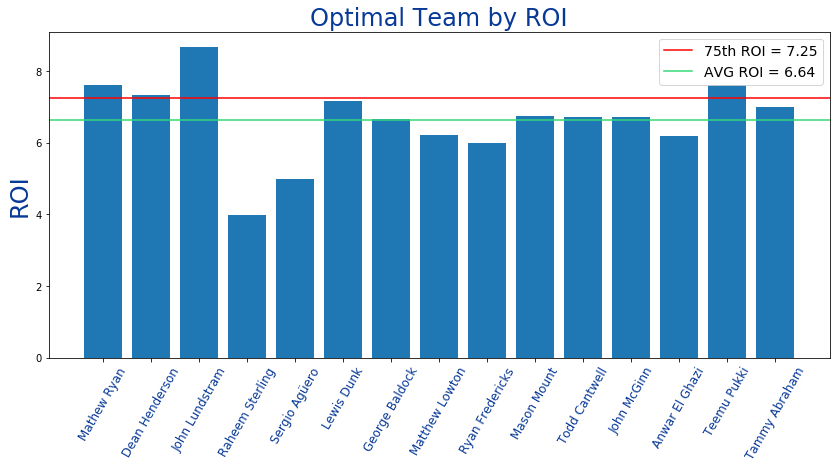

In [78]:
money_x = money_df.roi
money_y = money_df.name
ST_75th = round(money_df.describe().roi['75%'], 2)
ST_AVG = round(money_df.describe().roi['mean'], 2)

plt.bar(money_y, money_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th ROI = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ROI = ' + str(ST_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Optimal Team by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

### Top 10 ROI players by position

In [79]:
GK_df = pd.DataFrame(GK_roi)
GK_df.head(10)

bonus  cost  minutes                       name    position  pts_per_90min  \
0      6   4.6      720                Mathew Ryan  Goalkeeper           4.37   
1      2   4.5      720             Dean Henderson  Goalkeeper           4.12   
2      2   4.6      720                  Nick Pope  Goalkeeper           3.99   
3      3   4.5      720                 Angus Gunn  Goalkeeper           3.37   
4      3   4.5      720             Aaron Ramsdale  Goalkeeper           3.12   
5      1   5.0      720                 Bernd Leno  Goalkeeper           3.37   
6      0   6.1      720  Ederson Santana de Moraes  Goalkeeper           3.62   
7      5   4.8      720                 Ben Foster  Goalkeeper           2.75   
8      1   5.5      720            Jordan Pickford  Goalkeeper           3.00   
9      0   5.5      720          Kepa Arrizabalaga  Goalkeeper           2.00   

   red_cards   roi     status  team_code      team_name  total_points  \
0          0  7.61  available         36       Brighton            35   
1          0  7.33  available         49  Sheffield Utd            33   
2          0  6.96  available         90        Burnley            32   
3          0  6.00  available         20    Southampton            27   
4          0  5.56  available         91    Bournemouth            25   
5          0  5.40  available          3        Arsenal            27   
6          0  4.75  available         43       Man City            29   
7          0  4.58  available         57        Watford            22   
8          0  4.36  available         11        Everton            24   
9          0  2.91  available          8        Chelsea            16   

   transfers_in  transfers_out  
0        421255         337548  
1        170592          56480  
2        755173         197588  
3        228634          78414  
4         67454          21445  
5        255934         229084  
6        647791         481031  
7         14430          91073  
8        330608         363131  
9        160513         192682

In [80]:
DF_df = pd.DataFrame(DF_roi)
DF_df.head(10)

bonus  cost  minutes                name  position  pts_per_90min  \
0      7   4.5      688      John Lundstram  Defender           5.09   
1      7   4.6      720          Lewis Dunk  Defender           4.12   
2      3   4.5      720      George Baldock  Defender           3.74   
3      4   5.0      720        Enda Stevens  Defender           4.12   
4      0   4.5      720      Matthew Lowton  Defender           3.50   
5      2   4.5      709     Ryan Fredericks  Defender           3.42   
6      1   4.5      720           John Egan  Defender           3.37   
7      0   4.5      684        Chris Basham  Defender           3.42   
8      1   4.5      720      Jack O'Connell  Defender           3.25   
9      6   5.2      618  Jannik Vestergaard  Defender           4.22   

   red_cards   roi     status  team_code      team_name  total_points  \
0          0  8.67  available         49  Sheffield Utd            39   
1          0  7.17  available         36       Brighton            33   
2          0  6.67  available         49  Sheffield Utd            30   
3          0  6.60  available         49  Sheffield Utd            33   
4          0  6.22  available         90        Burnley            28   
5          0  6.00  available         21       West Ham            27   
6          0  6.00  available         49  Sheffield Utd            27   
7          0  5.78  available         49  Sheffield Utd            26   
8          0  5.78  available         49  Sheffield Utd            26   
9          0  5.58  available         20    Southampton            29   

   transfers_in  transfers_out  
0       1736854         216049  
1        504885         311510  
2         52042          21111  
3         36779          19930  
4         77125          28259  
5         68118          21242  
6          6336           5646  
7          6438           5684  
8          8413          12528  
9        500440         148342

In [81]:
MD_df = pd.DataFrame(MD_roi)
MD_df.head(10)

bonus  cost  minutes                     name    position  pts_per_90min  \
0      6   6.8      709              Mason Mount  Midfielder           5.83   
1      2   4.9      685            Todd Cantwell  Midfielder           4.33   
2      4   5.8      720              John McGinn  Midfielder           4.87   
3      0   5.5      484           Anwar El Ghazi  Midfielder           6.31   
4      5   5.1      682  Jorge Luiz Frello Filho  Midfielder           3.82   
5      5   6.0      453        Andriy Yarmolenko  Midfielder           6.74   
6      6   8.7      457             Riyad Mahrez  Midfielder           9.04   
7      3   7.6      482              David Silva  Midfielder           7.45   
8      2   4.7      691         Matteo Guendouzi  Midfielder           3.12   
9      2   6.1      575              Erik Lamela  Midfielder           4.84   

   red_cards   roi     status  team_code    team_name  total_points  \
0          0  6.76  available          8      Chelsea            46   
1          0  6.73  available         45      Norwich            33   
2          0  6.72  available          7  Aston Villa            39   
3          0  6.18  available          7  Aston Villa            34   
4          0  5.69  available          8      Chelsea            29   
5          0  5.67  available         21     West Ham            34   
6          0  5.29  available         43     Man City            46   
7          0  5.26  available         43     Man City            40   
8          0  5.11  available          3      Arsenal            24   
9          0  5.08  available          6        Spurs            31   

   transfers_in  transfers_out  
0       2670806         575891  
1       2077554         510244  
2        890508         297359  
3         76751          31059  
4        297552         207156  
5        425686          44343  
6        712702         271384  
7        725323         376245  
8        653190         315743  
9        464597         278682

In [82]:
ST_df = pd.DataFrame(ST_roi)
ST_df.head(10)

bonus  cost  minutes                       name position  pts_per_90min  \
0      9   7.1      705                Teemu Pukki  Forward           6.88   
1     11   7.7      569              Tammy Abraham  Forward           8.53   
2      7   6.0      694              Wesley Moraes  Forward           5.18   
3      4   7.9      697              Callum Wilson  Forward           6.19   
4      5   6.3      708                Joshua King  Forward           4.82   
5      5   5.9      441                 Danny Ings  Forward           6.72   
6      4   6.5      644              Ashley Barnes  Forward           4.74   
7      5   7.4      630           Sébastien Haller  Forward           5.28   
8     10  11.0      720  Pierre-Emerick Aubameyang  Forward           6.87   
9      6  12.2      560              Sergio Agüero  Forward           9.79   

   red_cards   roi     status  team_code    team_name  total_points  \
0          0  7.61  available         45      Norwich            54   
1          0  7.01  available          8      Chelsea            54   
2          0  6.67  available          7  Aston Villa            40   
3          0  6.08  available         91  Bournemouth            48   
4          0  6.03  available         91  Bournemouth            38   
5          0  5.59  available         20  Southampton            33   
6          0  5.23  available         90      Burnley            34   
7          0  5.00  available         21     West Ham            37   
8          0  5.00  available          3      Arsenal            55   
9          0  5.00  available         43     Man City            61   

   transfers_in  transfers_out  
0       3164050         897411  
1       2858820         360069  
2        232013         147572  
3        460024         778213  
4        376378         999613  
5        120372         162268  
6        987712         741421  
7        459099         392396  
8        899533         840377  
9       1167690         492953

## Define Clean df for graphing purposes

In [83]:
clean_df.head()

bonus  cost  minutes                           name    position  \
390      7   4.5      688                 John Lundstram    Defender   
96       6   4.6      720                    Mathew Ryan  Goalkeeper   
361      9   7.1      705                    Teemu Pukki     Forward   
538      4   5.1      720  Rui Pedro dos Santos Patrício  Goalkeeper   
403      2   4.5      720                 Dean Henderson  Goalkeeper   

     pts_per_90min  red_cards   roi     status  team_code      team_name  \
390           5.09          0  8.67  available         49  Sheffield Utd   
96            4.37          0  7.61  available         36       Brighton   
361           6.88          0  7.61  available         45        Norwich   
538           4.74          0  7.45  available         39         Wolves   
403           4.12          0  7.33  available         49  Sheffield Utd   

     total_points  transfers_in  transfers_out  
390            39       1736854         216049  
96             35        421255         337548  
361            54       3164050         897411  
538            38        477028         220992  
403            33        170592          56480

In [84]:
graph_roi = []
for row, player in clean_df.iterrows():
    playa = dict(name = player['name'], position = player.position, team=player.team_name, cost = player.cost, points = player.total_points, minutes = player.minutes, ROI = player.roi, pts_per_90min = player.pts_per_90min)
    graph_roi.append(playa)

In [85]:
graph_roi[:3]

[{'name': 'John Lundstram',
  'position': 'Defender',
  'team': 'Sheffield Utd',
  'cost': 4.5,
  'points': 39,
  'minutes': 688,
  'ROI': 8.67,
  'pts_per_90min': 5.09},
 {'name': 'Mathew Ryan',
  'position': 'Goalkeeper',
  'team': 'Brighton',
  'cost': 4.6,
  'points': 35,
  'minutes': 720,
  'ROI': 7.61,
  'pts_per_90min': 4.37},
 {'name': 'Teemu Pukki',
  'position': 'Forward',
  'team': 'Norwich',
  'cost': 7.1,
  'points': 54,
  'minutes': 705,
  'ROI': 7.61,
  'pts_per_90min': 6.88}]

### Graph by ROI

In [86]:
GK_graph = clean_df[clean_df['position'] == 'Goalkeeper']
DF_graph = clean_df[clean_df['position'] == 'Defender']
MD_graph = clean_df[clean_df['position'] == 'Midfielder']
ST_graph = clean_df[clean_df['position'] == 'Forward']

### Graph by 90_min Stat

In [87]:
sorted_players_90min = sorted(graph_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
sorted_players_90min = [player for player in sorted_players_90min if player['minutes'] >= min_min]

In [88]:
sorted_players_90min[:3]

[{'name': 'Sergio Agüero',
  'position': 'Forward',
  'team': 'Man City',
  'cost': 12.2,
  'points': 61,
  'minutes': 560,
  'ROI': 5.0,
  'pts_per_90min': 9.79},
 {'name': 'Divock Origi',
  'position': 'Forward',
  'team': 'Liverpool',
  'cost': 5.3,
  'points': 17,
  'minutes': 163,
  'ROI': 3.21,
  'pts_per_90min': 9.33},
 {'name': 'James Milner',
  'position': 'Midfielder',
  'team': 'Liverpool',
  'cost': 5.3,
  'points': 23,
  'minutes': 225,
  'ROI': 4.34,
  'pts_per_90min': 9.16}]

In [89]:
df_90min = pd.DataFrame(sorted_players_90min)

In [90]:
df_90min.head()

ROI  cost  minutes           name  points    position  pts_per_90min  \
0  5.00  12.2      560  Sergio Agüero      61     Forward           9.79   
1  3.21   5.3      163   Divock Origi      17     Forward           9.33   
2  4.34   5.3      225   James Milner      23  Midfielder           9.16   
3  5.29   8.7      457   Riyad Mahrez      46  Midfielder           9.04   
4  7.01   7.7      569  Tammy Abraham      54     Forward           8.53   

        team  
0   Man City  
1  Liverpool  
2  Liverpool  
3   Man City  
4    Chelsea

In [91]:
GK_90min_graph = df_90min[df_90min['position'] == 'Goalkeeper']
DF_90min_graph = df_90min[df_90min['position'] == 'Defender']
MD_90min_graph = df_90min[df_90min['position'] == 'Midfielder']
ST_90min_graph = df_90min[df_90min['position'] == 'Forward']

In [92]:
GK_90min_graph.head()

ROI  cost  minutes                           name  points    position  \
22  2.75   4.0      158               Michael McGovern      11  Goalkeeper   
56  7.45   5.1      720  Rui Pedro dos Santos Patrício      38  Goalkeeper   
67  7.61   4.6      720                    Mathew Ryan      35  Goalkeeper   
77  7.33   4.5      720                 Dean Henderson      33  Goalkeeper   
90  6.96   4.6      720                      Nick Pope      32  Goalkeeper   

    pts_per_90min           team  
22           6.23        Norwich  
56           4.74         Wolves  
67           4.37       Brighton  
77           4.12  Sheffield Utd  
90           3.99        Burnley

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

## Top 10 Keepers ROI

<function matplotlib.pyplot.show(*args, **kw)>

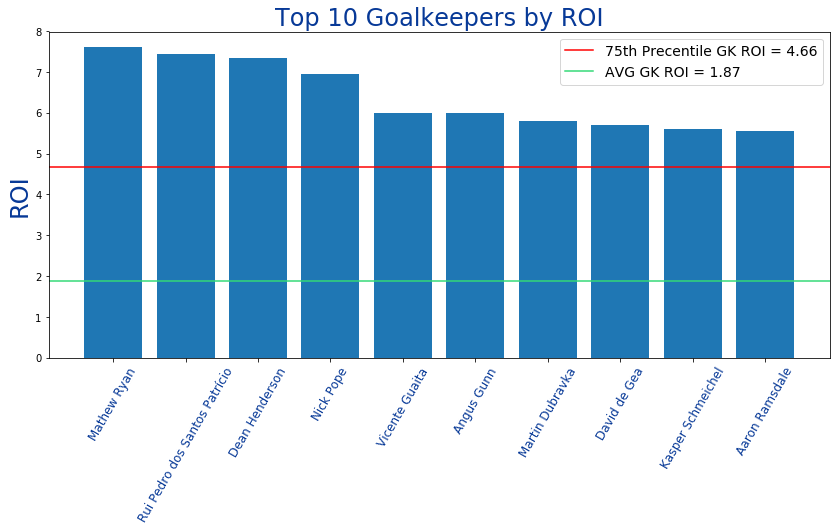

In [94]:
GK_x = GK_graph[:10].roi
GK_y = GK_graph[:10].name
GK_75th = round(GK_graph.describe().roi['75%'], 2)
GK_AVG = round(GK_graph.describe().roi['mean'], 2)

plt.bar(GK_y, GK_x)
plt.axhline(y=GK_75th, color='r', linestyle='-', label='75th Precentile GK ROI = ' + str(GK_75th))
plt.axhline(y=GK_AVG, color='#33D977', linestyle='-', label='AVG GK ROI = ' + str(GK_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Goalkeepers by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Keepers 90_min

<function matplotlib.pyplot.show(*args, **kw)>

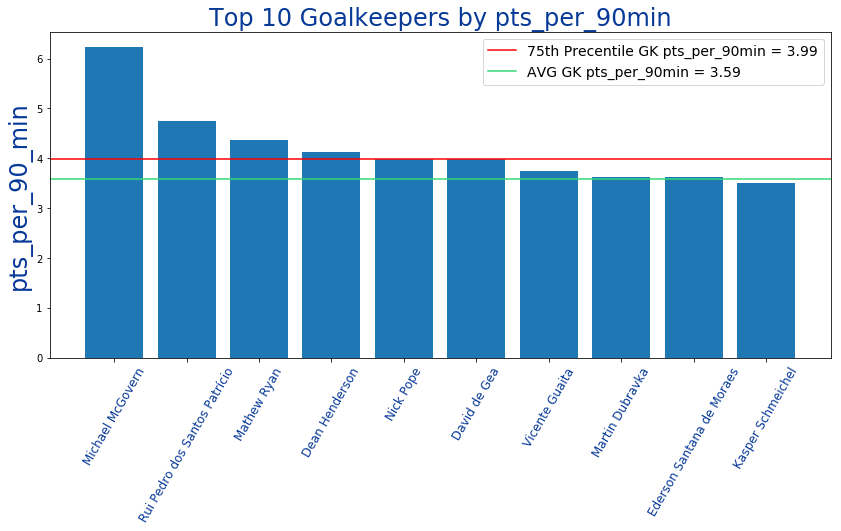

In [95]:
GK_x = GK_90min_graph[:10].pts_per_90min
GK_y = GK_90min_graph[:10].name
GK_75th = round(GK_90min_graph.describe().pts_per_90min['75%'], 2)
GK_AVG = round(GK_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(GK_y, GK_x)
plt.axhline(y=GK_75th, color='r', linestyle='-', label='75th Precentile GK pts_per_90min = ' + str(GK_75th))
plt.axhline(y=GK_AVG, color='#33D977', linestyle='-', label='AVG GK pts_per_90min = ' + str(GK_AVG))
plt.ylabel('pts_per_90_min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Goalkeepers by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Defenders

<function matplotlib.pyplot.show(*args, **kw)>

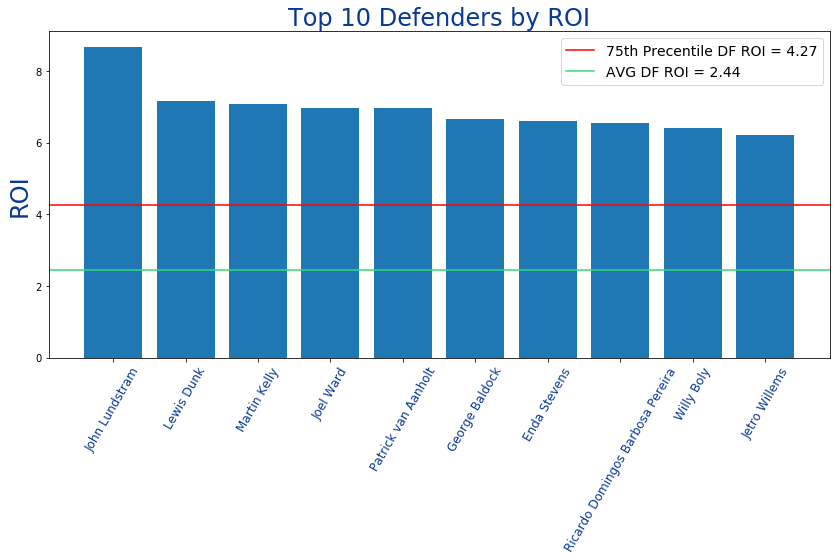

In [96]:
DF_x = DF_graph[:10].roi
DF_y = DF_graph[:10].name
DF_75th = round(DF_graph.describe().roi['75%'], 2)
DF_AVG = round(DF_graph.describe().roi['mean'], 2)

plt.bar(DF_y, DF_x)
plt.axhline(y=DF_75th, color='r', linestyle='-', label='75th Precentile DF ROI = ' + str(DF_75th))
plt.axhline(y=DF_AVG, color='#33D977', linestyle='-', label='AVG DF ROI = ' + str(DF_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Defenders by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Defenders 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

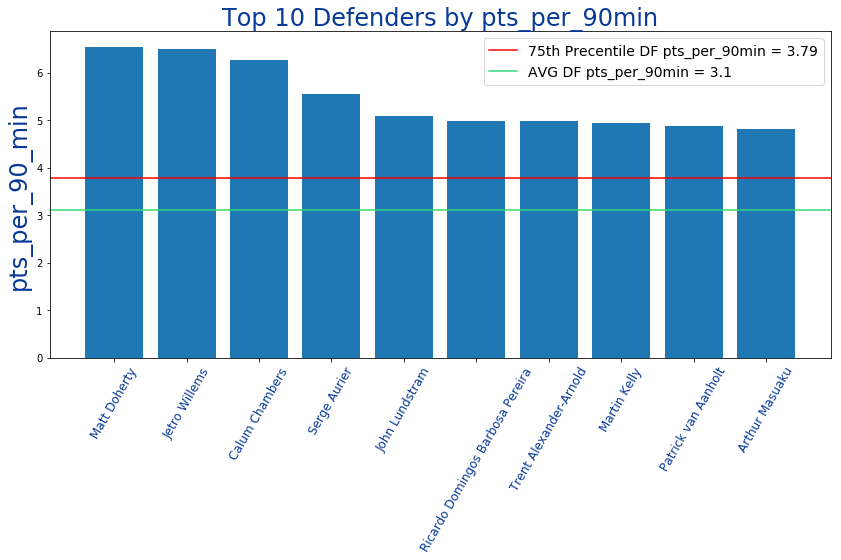

In [97]:
DF_x = DF_90min_graph[:10].pts_per_90min
DF_y = DF_90min_graph[:10].name
DF_75th = round(DF_90min_graph.describe().pts_per_90min['75%'], 2)
DF_AVG = round(DF_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(DF_y, DF_x)
plt.axhline(y=DF_75th, color='r', linestyle='-', label='75th Precentile DF pts_per_90min = ' + str(DF_75th))
plt.axhline(y=DF_AVG, color='#33D977', linestyle='-', label='AVG DF pts_per_90min = ' + str(DF_AVG))
plt.ylabel('pts_per_90_min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Defenders by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Midfielders

<function matplotlib.pyplot.show(*args, **kw)>

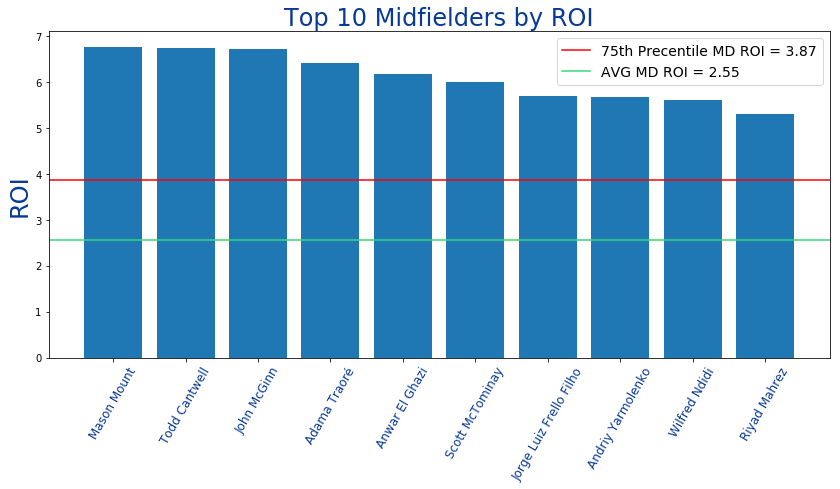

In [98]:
MD_x = MD_graph[:10].roi
MD_y = MD_graph[:10].name
MD_75th = round(MD_graph.describe().roi['75%'], 2)
MD_AVG = round(MD_graph.describe().roi['mean'], 2)

plt.bar(MD_y, MD_x)
plt.axhline(y=MD_75th, color='r', linestyle='-', label='75th Precentile MD ROI = ' + str(MD_75th))
plt.axhline(y=MD_AVG, color='#33D977', linestyle='-', label='AVG MD ROI = ' + str(MD_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Midfielders by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Midfielders 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

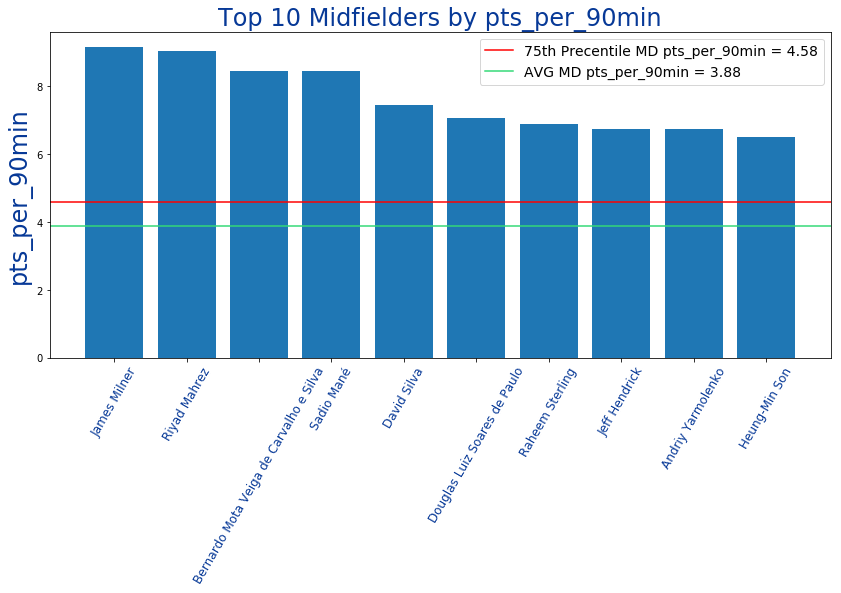

In [99]:
MD_x = MD_90min_graph[:10].pts_per_90min
MD_y = MD_90min_graph[:10].name
MD_75th = round(MD_90min_graph.describe().pts_per_90min['75%'], 2)
MD_AVG = round(MD_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(MD_y, MD_x)
plt.axhline(y=MD_75th, color='r', linestyle='-', label='75th Precentile MD pts_per_90min = ' + str(MD_75th))
plt.axhline(y=MD_AVG, color='#33D977', linestyle='-', label='AVG MD pts_per_90min = ' + str(MD_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Midfielders by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Strikers

<function matplotlib.pyplot.show(*args, **kw)>

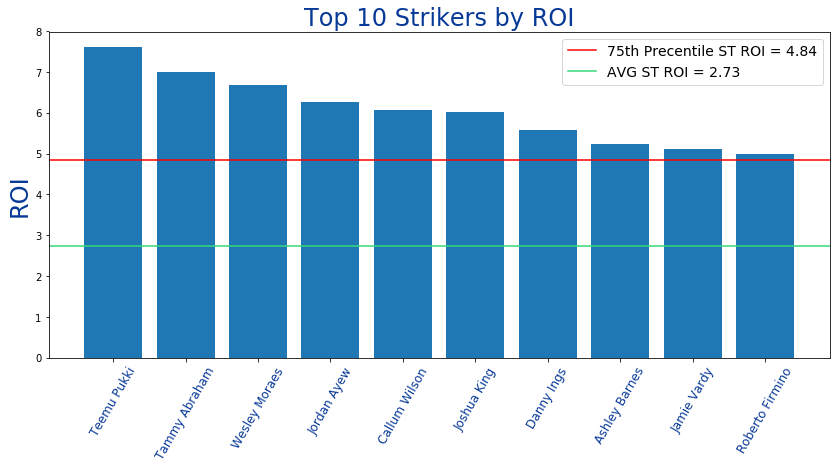

In [100]:
ST_x = ST_graph[:10].roi
ST_y = ST_graph[:10].name
ST_75th = round(ST_graph.describe().roi['75%'], 2)
ST_AVG = round(ST_graph.describe().roi['mean'], 2)

plt.bar(ST_y, ST_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile ST ROI = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ST ROI = ' + str(ST_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Strikers by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Strikers 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

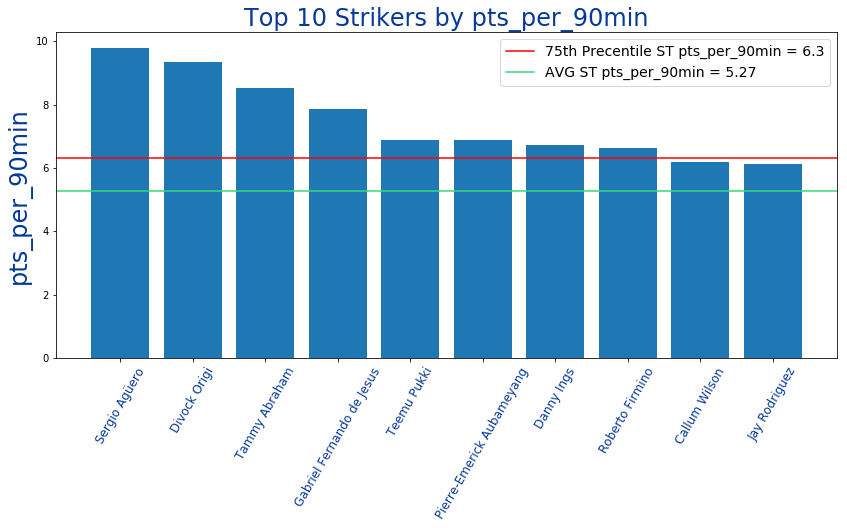

In [101]:
ST_x = ST_90min_graph[:10].pts_per_90min
ST_y = ST_90min_graph[:10].name
ST_75th = round(ST_90min_graph.describe().pts_per_90min['75%'], 2)
ST_AVG = round(ST_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(ST_y, ST_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile ST pts_per_90min = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ST pts_per_90min = ' + str(ST_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Strikers by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [102]:
team_df

code  strength Team            name Played  W  L  D  GF  GA   GD Pts
Position                                                                      
1           14         5  LIV       Liverpool      8  8  0  0  20   6  +14  24
2           43         5  MCI        Man City      8  5  2  1  27   9  +18  16
3            3         4  ARS         Arsenal      8  4  1  3  13  11   +2  15
4           13         3  LEI       Leicester      8  4  2  2  14   7   +7  14
5            8         4  CHE         Chelsea      8  4  2  2  18  14   +4  14
6           31         3  CRY  Crystal Palace      8  4  2  2   8   8    0  14
7           90         3  BUR         Burnley      8  3  2  3  11   9   +2  12
8           21         3  WHU        West Ham      8  3  2  3  11  11    0  12
9            6         4  TOT           Spurs      8  3  3  2  14  12   +2  11
10          91         3  BOU     Bournemouth      8  3  3  2  13  13    0  11
11          39         3  WOL          Wolves      8  2  2  4  11  11    0  10
12           1         4  MUN         Man Utd      8  2  3  3   9   8   +1   9
13          49         2  SHU   Sheffield Utd      8  2  3  3   7   7    0   9
14          36         2  BHA        Brighton      8  2  3  3   8  10   -2   9
15           7         2  AVL     Aston Villa      8  2  4  2  13  12   +1   8
16           4         3  NEW       Newcastle      8  2  4  2   5  13   -8   8
17          20         3  SOU     Southampton      8  2  5  1   8  15   -7   7
18          11         3  EVE         Everton      8  2  5  1   6  13   -7   7
19          45         3  NOR         Norwich      8  2  6  0  10  21  -11   6
20          57         2  WAT         Watford      8  0  5  3   4  20  -16   3

### Team Stats

In [103]:
teams_stats = team_df.iloc[:,2:12]

In [104]:
teams_stats.GF = [int(item) for item in teams_stats.GF]
teams_stats.GA = [int(item) for item in teams_stats.GA]

In [105]:
teams_stats

Team            name Played  W  L  D  GF  GA   GD Pts
Position                                                      
1         LIV       Liverpool      8  8  0  0  20   6  +14  24
2         MCI        Man City      8  5  2  1  27   9  +18  16
3         ARS         Arsenal      8  4  1  3  13  11   +2  15
4         LEI       Leicester      8  4  2  2  14   7   +7  14
5         CHE         Chelsea      8  4  2  2  18  14   +4  14
6         CRY  Crystal Palace      8  4  2  2   8   8    0  14
7         BUR         Burnley      8  3  2  3  11   9   +2  12
8         WHU        West Ham      8  3  2  3  11  11    0  12
9         TOT           Spurs      8  3  3  2  14  12   +2  11
10        BOU     Bournemouth      8  3  3  2  13  13    0  11
11        WOL          Wolves      8  2  2  4  11  11    0  10
12        MUN         Man Utd      8  2  3  3   9   8   +1   9
13        SHU   Sheffield Utd      8  2  3  3   7   7    0   9
14        BHA        Brighton      8  2  3  3   8  10   -2   9
15        AVL     Aston Villa      8  2  4  2  13  12   +1   8
16        NEW       Newcastle      8  2  4  2   5  13   -8   8
17        SOU     Southampton      8  2  5  1   8  15   -7   7
18        EVE         Everton      8  2  5  1   6  13   -7   7
19        NOR         Norwich      8  2  6  0  10  21  -11   6
20        WAT         Watford      8  0  5  3   4  20  -16   3

### Worst/ Best  Defence vs. Offence

In [106]:
worst_defence_df = teams_stats.sort_values(by = ['GA'], ascending = False)

In [107]:
worst_defence_df.head()

Team         name Played  W  L  D  GF  GA   GD Pts
Position                                                   
19        NOR      Norwich      8  2  6  0  10  21  -11   6
20        WAT      Watford      8  0  5  3   4  20  -16   3
17        SOU  Southampton      8  2  5  1   8  15   -7   7
5         CHE      Chelsea      8  4  2  2  18  14   +4  14
10        BOU  Bournemouth      8  3  3  2  13  13    0  11

In [108]:
best_defence_df = teams_stats.sort_values(by = ['GA'], ascending = True)

In [109]:
best_defence_df.head()

Team            name Played  W  L  D  GF  GA   GD Pts
Position                                                      
1         LIV       Liverpool      8  8  0  0  20   6  +14  24
4         LEI       Leicester      8  4  2  2  14   7   +7  14
13        SHU   Sheffield Utd      8  2  3  3   7   7    0   9
6         CRY  Crystal Palace      8  4  2  2   8   8    0  14
12        MUN         Man Utd      8  2  3  3   9   8   +1   9

In [110]:
GA = list(zip(worst_defence_df.name, worst_defence_df.GA))
GA_bottom5 = GA[:7]
GA_top5 = sorted(GA[-7:], key = lambda x: x[1])

In [111]:
GA_bottom5, GA_top5

([('Norwich', 21),
  ('Watford', 20),
  ('Southampton', 15),
  ('Chelsea', 14),
  ('Bournemouth', 13),
  ('Everton', 13),
  ('Newcastle', 13)],
 [('Liverpool', 6),
  ('Sheffield Utd', 7),
  ('Leicester', 7),
  ('Man Utd', 8),
  ('Crystal Palace', 8),
  ('Man City', 9),
  ('Burnley', 9)])

In [112]:
teams_stats.GA.median()

11.0

<function matplotlib.pyplot.show(*args, **kw)>

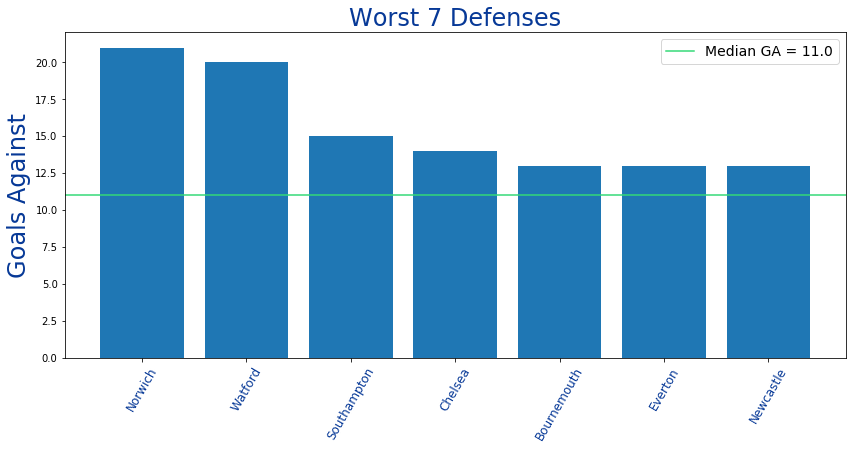

In [113]:
X = [item[0] for item in GA_bottom5]
Y = [int(item[1]) for item in GA_bottom5]

median = teams_stats.GA.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GA = ' + str(median))
plt.ylabel('Goals Against', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Worst 7 Defenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

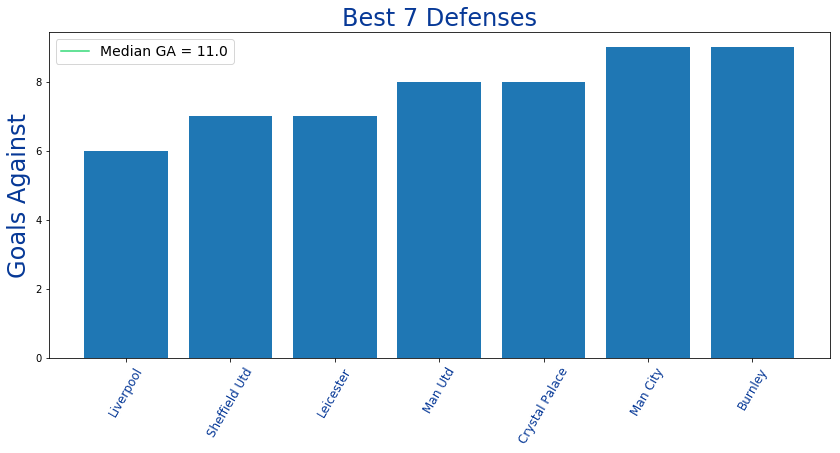

In [114]:
X = [item[0] for item in GA_top5]
Y = [int(item[1]) for item in GA_top5]

median = teams_stats.GA.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GA = ' + str(median))
plt.ylabel('Goals Against', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Best 7 Defenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.show

In [115]:
offense_df = teams_stats.sort_values(by = ['GF'], ascending = False)

In [116]:
offense_df.head()

Team       name Played  W  L  D  GF  GA   GD Pts
Position                                                 
2         MCI   Man City      8  5  2  1  27   9  +18  16
1         LIV  Liverpool      8  8  0  0  20   6  +14  24
5         CHE    Chelsea      8  4  2  2  18  14   +4  14
9         TOT      Spurs      8  3  3  2  14  12   +2  11
4         LEI  Leicester      8  4  2  2  14   7   +7  14

In [117]:
GF = list(zip(offense_df.name, offense_df.GF))
GF_top5 = GF[:7]
GF_bottom5 = GF[-7:]

In [118]:
GF_top5, GF_bottom5

([('Man City', 27),
  ('Liverpool', 20),
  ('Chelsea', 18),
  ('Spurs', 14),
  ('Leicester', 14),
  ('Arsenal', 13),
  ('Aston Villa', 13)],
 [('Brighton', 8),
  ('Crystal Palace', 8),
  ('Southampton', 8),
  ('Sheffield Utd', 7),
  ('Everton', 6),
  ('Newcastle', 5),
  ('Watford', 4)])

<function matplotlib.pyplot.show(*args, **kw)>

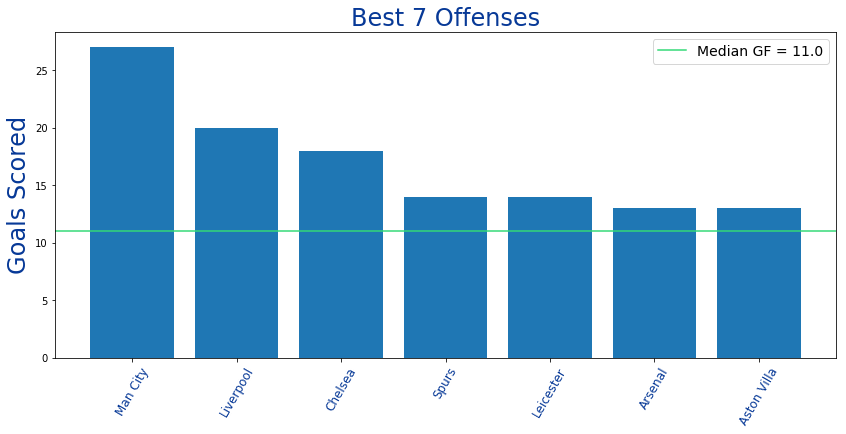

In [119]:
X = [item[0] for item in GF_top5]
Y = [int(item[1]) for item in GF_top5]

median = teams_stats.GF.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Goals Scored', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Best 7 Offenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

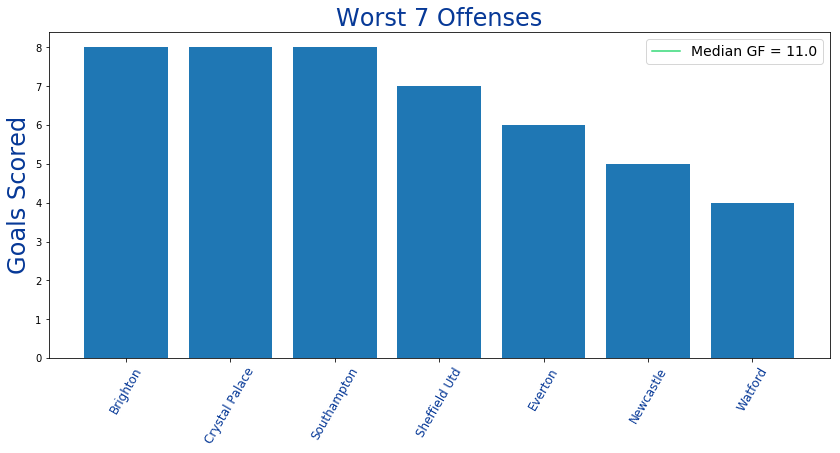

In [120]:
X = [item[0] for item in GF_bottom5]
Y = [int(item[1]) for item in GF_bottom5]

median = teams_stats.GF.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Goals Scored', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Worst 7 Offenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.show

In [121]:
stats_df = player_df[player_df.minutes >= min_min]

In [122]:
stats_df.tail()

bonus  cost  minutes                name  position  pts_per_90min  \
357      0   4.4      540  Maximillian Aarons  Defender           0.50   
480      0   6.2      180         Troy Deeney   Forward           1.99   
170      0   5.0      191       Mamadou Sakho  Defender           1.41   
377      0   4.4      181           Sam Byram  Defender           0.99   
360      0   4.0      270        Grant Hanley  Defender           0.33   

     red_cards   roi     status  team_code       team_name  total_points  \
357          0  0.68  available         45         Norwich             3   
480          0  0.65    injured         57         Watford             4   
170          0  0.60   doubtful         31  Crystal Palace             3   
377          0  0.45  available         45         Norwich             2   
360          0  0.25    injured         45         Norwich             1   

     transfers_in  transfers_out  
357         27055         119517  
480         15092         168964  
170          2677           5039  
377          3929           5617  
360        210497         154572

### Cobine Team and Player Stats

In [123]:
team_dic = {item:[] for item in team_names}

for row, player in stats_df.iterrows():
    for name in team_names:
        if player.team_name == name:
            playa = dict(name = player['name'], position = player.position, cost = player.cost, minutes = player.minutes, 
                         points = player.total_points,  roi = player.roi, pts_per_90min = player.pts_per_90min, 
                         bonus = player.bonus, red_cards = player.red_cards)
            team_dic[name].append(playa)

In [124]:
stats_df.head()

bonus  cost  minutes                           name    position  \
390      7   4.5      688                 John Lundstram    Defender   
96       6   4.6      720                    Mathew Ryan  Goalkeeper   
361      9   7.1      705                    Teemu Pukki     Forward   
538      4   5.1      720  Rui Pedro dos Santos Patrício  Goalkeeper   
403      2   4.5      720                 Dean Henderson  Goalkeeper   

     pts_per_90min  red_cards   roi     status  team_code      team_name  \
390           5.09          0  8.67  available         49  Sheffield Utd   
96            4.37          0  7.61  available         36       Brighton   
361           6.88          0  7.61  available         45        Norwich   
538           4.74          0  7.45  available         39         Wolves   
403           4.12          0  7.33  available         49  Sheffield Utd   

     total_points  transfers_in  transfers_out  
390            39       1736854         216049  
96             35        421255         337548  
361            54       3164050         897411  
538            38        477028         220992  
403            33        170592          56480

In [125]:
team_dic['Liverpool']

[{'name': 'Trent Alexander-Arnold',
  'position': 'Defender',
  'cost': 7.2,
  'minutes': 720,
  'points': 40,
  'roi': 5.56,
  'pts_per_90min': 4.99,
  'bonus': 3,
  'red_cards': 0},
 {'name': 'Joel Matip',
  'position': 'Defender',
  'cost': 5.5,
  'minutes': 540,
  'points': 30,
  'roi': 5.45,
  'pts_per_90min': 4.99,
  'bonus': 4,
  'red_cards': 0},
 {'name': 'Virgil van Dijk',
  'position': 'Defender',
  'cost': 6.5,
  'minutes': 720,
  'points': 33,
  'roi': 5.08,
  'pts_per_90min': 4.12,
  'bonus': 3,
  'red_cards': 0},
 {'name': 'Adrián San Miguel del Castillo',
  'position': 'Goalkeeper',
  'cost': 4.6,
  'minutes': 681,
  'points': 23,
  'roi': 5.0,
  'pts_per_90min': 3.04,
  'bonus': 0,
  'red_cards': 0},
 {'name': 'Roberto Firmino',
  'position': 'Forward',
  'cost': 9.6,
  'minutes': 650,
  'points': 48,
  'roi': 5.0,
  'pts_per_90min': 6.64,
  'bonus': 9,
  'red_cards': 0},
 {'name': 'Georginio Wijnaldum',
  'position': 'Midfielder',
  'cost': 5.4,
  'minutes': 678,
  'po

### Get Final Stats per Team using Pandas

In [126]:
team_stats = {item:{} for item in team_names}

for team in team_names:
    active_players = len(stats_df[stats_df.team_name == team].cost)
    tot_cost = round(stats_df[stats_df.team_name == team].cost.sum(), 3)
    tot_pts = round(stats_df[stats_df.team_name == team].total_points.sum(), 3)
    avg_player_roi = round(tot_pts / tot_cost, 3)
    avg_pts_per_player = round(tot_pts / active_players, 3)
    
    stats = dict(active_players = active_players, tot_cost = tot_cost, tot_pts = tot_pts,
               avg_pts_per_player = avg_pts_per_player,  avg_player_roi =  avg_player_roi)
    
    team_stats[team].update(stats)
    
    

In [127]:
team_stats['Newcastle']

{'active_players': 14,
 'tot_cost': 69.1,
 'tot_pts': 256,
 'avg_pts_per_player': 18.286,
 'avg_player_roi': 3.705}

In [128]:
team_stats_df = pd.DataFrame(team_stats).T

In [129]:
team_stats_df.sort_values(by = ['avg_pts_per_player'], ascending = False, inplace = True)

In [130]:
team_stats_df

active_players  avg_player_roi  avg_pts_per_player  tot_cost  \
Liverpool                 14.0           4.365              30.429      97.6   
Man City                  16.0           3.870              28.688     118.6   
West Ham                  13.0           4.520              24.615      70.8   
Burnley                   14.0           4.465              23.857      74.8   
Leicester                 15.0           4.172              23.667      85.1   
Sheffield Utd             13.0           4.717              23.077      63.6   
Wolves                    15.0           4.192              22.133      79.2   
Aston Villa               15.0           4.333              21.867      75.7   
Crystal Palace            15.0           3.934              20.667      78.8   
Arsenal                   15.0           3.571              20.400      85.7   
Chelsea                   16.0           3.259              19.188      94.2   
Bournemouth               14.0           3.594              19.071      74.3   
Spurs                     16.0           2.988              18.750     100.4   
Brighton                  15.0           3.742              18.733      75.1   
Newcastle                 14.0           3.705              18.286      69.1   
Man Utd                   16.0           3.060              18.188      95.1   
Everton                   14.0           2.989              17.786      83.3   
Southampton               15.0           3.329              16.867      76.0   
Norwich                   15.0           3.093              14.867      72.1   
Watford                   17.0           2.269              11.824      88.6   

                tot_pts  
Liverpool         426.0  
Man City          459.0  
West Ham          320.0  
Burnley           334.0  
Leicester         355.0  
Sheffield Utd     300.0  
Wolves            332.0  
Aston Villa       328.0  
Crystal Palace    310.0  
Arsenal           306.0  
Chelsea           307.0  
Bournemouth       267.0  
Spurs             300.0  
Brighton          281.0  
Newcastle         256.0  
Man Utd           291.0  
Everton           249.0  
Southampton       253.0  
Norwich           223.0  
Watford           201.0

### Build a team using 90min Stat

In [131]:
#define money team as empty list and list that tracks count of players selectd per team
money_team = []
players_selected = []
teams_selected = []

#Instantiate initial count per position
#Current players selected for each position
DF_curr = 0
MD_curr = 0 
ST_curr = 0

GK_budget = budget*GK_coef
print(GK_budget)

for item in GK_90min:
    if item['cost'] <= 5.5 and item['cost'] <= GK_budget:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        GK_budget -= item['cost']
        print('Player Selected: ' + item['name'])
        print('GK budget left: ' + str(GK_budget))

print(players_selected)
print(teams_selected)

9.5
Player Selected: Michael McGovern
GK budget left: 5.5
Player Selected: Mathew Ryan
GK budget left: 0.9000000000000004
['Michael McGovern', 'Mathew Ryan']
['Norwich', 'Brighton']


### Select top 3 players by points per position

In [132]:
DF_budget = budget*DF_coef + GK_budget
MD_budget = budget*MD_coef
ST_budget = budget*ST_coef

print(DF_budget, MD_budget, ST_budget)

#Select Top Defender
money_team.append(DF_pts[0])
players_selected.append(DF_pts[0]['name'])
teams_selected.append(DF_pts[0]['team_name'])
DF_budget -= DF_pts[0]['cost']
DF_curr += 1
print('Player Selected: ' + DF_pts[0]['name'])
print('DF budget left: ' + str(DF_budget))

#Select Top Midfielder
money_team.append(MD_pts[0])
players_selected.append(MD_pts[0]['name'])
teams_selected.append(MD_pts[0]['team_name'])
MD_budget -= MD_pts[0]['cost']
MD_curr += 1
print('Player Selected: ' + MD_pts[0]['name'])
print('MD budget left: ' + str(MD_budget))


print(players_selected)
print(teams_selected)

29.4 36.0 26.0
Player Selected: John Lundstram
DF budget left: 24.9
Player Selected: Raheem Sterling
MD budget left: 23.9
['Michael McGovern', 'Mathew Ryan', 'John Lundstram', 'Raheem Sterling']
['Norwich', 'Brighton', 'Sheffield Utd', 'Man City']


In [133]:
#Select Top Striker

for item in ST_pts[:3]:
    if teams_selected.count(item['team_name']) < 3 and len(money_team) == 4:
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
    break

print(len(money_team))
print(players_selected)
print(teams_selected)

Player Selected: Sergio Agüero
ST budget left: 13.8
5
['Michael McGovern', 'Mathew Ryan', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero']
['Norwich', 'Brighton', 'Sheffield Utd', 'Man City', 'Man City']


In [134]:
print(DF_curr, MD_curr, ST_curr)

1 1 1


In [135]:
print(DF, MD, ST)

3 4 3


### Fill rest of team with 90_min_stats

In [136]:
for item in DF_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < DF_budget and DF_curr < DF:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        DF_budget -= item['cost']
        DF_curr += 1
        print('Player Selected: ' + item['name'])
        print('DF budget left: ' + str(DF_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and DF_max != DF_curr and item['cost'] <= DF_budget / (DF_max - DF_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            DF_budget -= item['cost']
            DF_curr += 1
            print('Player Selected: ' + item['name'])
            print('DF budget left: ' + str(DF_budget))
            print('# of DFs selected: ' + str(DF_curr))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Calum Chambers
DF budget left: 20.5
Player Selected: Serge Aurier
DF budget left: 15.6
Player Selected: Arthur Masuaku
DF budget left: 11.1
# of DFs selected: 4
Player Selected: Jannik Vestergaard
DF budget left: 5.8999999999999995
# of DFs selected: 5
9
['Michael McGovern', 'Mathew Ryan', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero', 'Calum Chambers', 'Serge Aurier', 'Arthur Masuaku', 'Jannik Vestergaard']
['Norwich', 'Brighton', 'Sheffield Utd', 'Man City', 'Man City', 'Arsenal', 'Spurs', 'West Ham', 'Southampton']


In [137]:
#move leftover DF budget to MD budget
MD_budget += DF_budget

for item in MD_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < MD_budget and MD_curr < MD:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        MD_budget -= item['cost']
        MD_curr += 1
        print('Player Selected: ' + item['name'])
        print('MD budget left: ' + str(MD_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and MD_max != MD_curr and item['cost'] <= MD_budget / (MD_max - MD_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            MD_budget -= item['cost']
            MD_curr += 1
            print('Player Selected: ' + item['name'])
            print('MD budget left: ' + str(MD_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Riyad Mahrez
MD budget left: 21.099999999999998
Player Selected: Douglas Luiz Soares de Paulo
MD budget left: 16.599999999999998
Player Selected: Jeff Hendrick
MD budget left: 11.199999999999998
Player Selected: Andriy Yarmolenko
MD budget left: 5.1999999999999975
13
['Michael McGovern', 'Mathew Ryan', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero', 'Calum Chambers', 'Serge Aurier', 'Arthur Masuaku', 'Jannik Vestergaard', 'Riyad Mahrez', 'Douglas Luiz Soares de Paulo', 'Jeff Hendrick', 'Andriy Yarmolenko']
['Norwich', 'Brighton', 'Sheffield Utd', 'Man City', 'Man City', 'Arsenal', 'Spurs', 'West Ham', 'Southampton', 'Man City', 'Aston Villa', 'Burnley', 'West Ham']


In [138]:
#move leftover MD budget to ST budget
ST_budget += MD_budget

for item in ST_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < ST_budget and ST_curr < ST:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        ST_budget -= item['cost']
        ST_curr += 1
        print('Player Selected: ' + item['name'])
        print('ST budget left: ' + str(ST_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and ST_max != ST_curr and item['cost'] <= ST_budget / (ST_max - ST_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Tammy Abraham
ST budget left: 11.3
Player Selected: Teemu Pukki
ST budget left: 4.200000000000001
15
['Michael McGovern', 'Mathew Ryan', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero', 'Calum Chambers', 'Serge Aurier', 'Arthur Masuaku', 'Jannik Vestergaard', 'Riyad Mahrez', 'Douglas Luiz Soares de Paulo', 'Jeff Hendrick', 'Andriy Yarmolenko', 'Tammy Abraham', 'Teemu Pukki']
['Norwich', 'Brighton', 'Sheffield Utd', 'Man City', 'Man City', 'Arsenal', 'Spurs', 'West Ham', 'Southampton', 'Man City', 'Aston Villa', 'Burnley', 'West Ham', 'Chelsea', 'Norwich']


In [139]:
money_df = pd.DataFrame(money_team)

In [140]:
money_df

bonus  cost  minutes                          name    position  \
0       2   4.0      158              Michael McGovern  Goalkeeper   
1       6   4.6      720                   Mathew Ryan  Goalkeeper   
2       7   4.5      688                John Lundstram    Defender   
3       4  12.1      625               Raheem Sterling  Midfielder   
4       6  12.2      560                 Sergio Agüero     Forward   
5       2   4.4      315                Calum Chambers    Defender   
6       2   4.9      210                  Serge Aurier    Defender   
7       3   4.5      336                Arthur Masuaku    Defender   
8       6   5.2      618            Jannik Vestergaard    Defender   
9       6   8.7      457                  Riyad Mahrez  Midfielder   
10      2   4.5      279  Douglas Luiz Soares de Paulo  Midfielder   
11      4   5.4      305                 Jeff Hendrick  Midfielder   
12      5   6.0      453             Andriy Yarmolenko  Midfielder   
13     11   7.7      569                 Tammy Abraham     Forward   
14      9   7.1      705                   Teemu Pukki     Forward   

    pts_per_90min  red_cards   roi     status  team_code      team_name  \
0            6.23          0  2.75  available         45        Norwich   
1            4.37          0  7.61  available         36       Brighton   
2            5.09          0  8.67  available         49  Sheffield Utd   
3            6.90          0  3.97  available         43       Man City   
4            9.79          0  5.00  available         43       Man City   
5            6.27          0  5.00  available          3        Arsenal   
6            5.55          1  2.65  available          6          Spurs   
7            4.81          1  4.00  available         21       West Ham   
8            4.22          0  5.58  available         20    Southampton   
9            9.04          0  5.29  available         43       Man City   
10           7.07          0  4.89  available          7    Aston Villa   
11           6.76          0  4.26  available         90        Burnley   
12           6.74          0  5.67  available         21       West Ham   
13           8.53          0  7.01  available          8        Chelsea   
14           6.88          0  7.61  available         45        Norwich   

    total_points  transfers_in  transfers_out  
0             11        138938          76641  
1             35        421255         337548  
2             39       1736854         216049  
3             48       1281896         942011  
4             61       1167690         492953  
5             22         63023          51279  
6             13        255435         160813  
7             18         85390          59262  
8             29        500440         148342  
9             46        712702         271384  
10            22        410647         225635  
11            23          4054           4408  
12            34        425686          44343  
13            54       2858820         360069  
14            54       3164050         897411

<function matplotlib.pyplot.show(*args, **kw)>

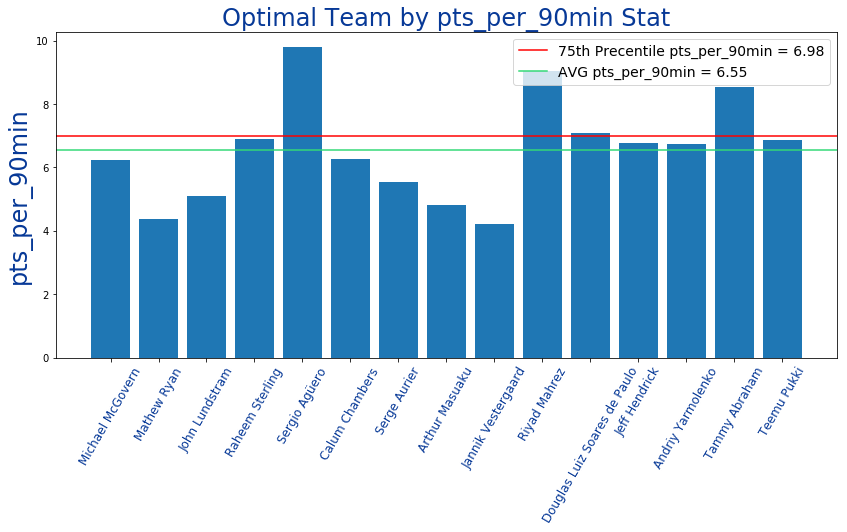

In [141]:
money_x = money_df.pts_per_90min
money_y = money_df.name
ST_75th = round(money_df.describe().pts_per_90min['75%'], 2)
ST_AVG = round(money_df.describe().pts_per_90min['mean'], 2)

plt.bar(money_y, money_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile pts_per_90min = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG pts_per_90min = ' + str(ST_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Optimal Team by pts_per_90min Stat', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [16]:
top100_users = pd.read_csv('fEPL_user_data_test.csv', index_col='users')

In [17]:
top100_users.head()

rank  user_id_num  total_points  game_week_points  \
users                                                                      
nick tanner               1       568651           587                65   
Boyko Iliev               2       191908           578                57   
Kittipong Kaewsopon       3       406431           573                59   
Raushan Uttamchandani     4      1229681           569                54   
david croley              4      1966144           569                43   

                                                      formation  \
users                                                             
nick tanner            {'GKP': 1, 'DEF': 3, 'MID': 5, 'FWD': 2}   
Boyko Iliev            {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   
Kittipong Kaewsopon    {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   
Raushan Uttamchandani  {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   
david croley           {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   

                                  GKP_1               GKP_2  \
users                                                         
nick tanner              Ryan-BHA-start    McGovern-NOR-sub   
Boyko Iliev              Pope-BUR-start    Patrício-WOL-sub   
Kittipong Kaewsopon      Ryan-BHA-start  Schmeichel-LEI-sub   
Raushan Uttamchandani    Ryan-BHA-start    McGovern-NOR-sub   
david croley           Heaton-AVL-start        Ryan-BHA-sub   

                                            DEF_1                DEF_2  \
users                                                                    
nick tanner                       Kelly-CRY-start       Dunk-BHA-start   
Boyko Iliev            Alexander-Arnold-LIV-start  O'Connell-SHU-start   
Kittipong Kaewsopon            van Dijk-LIV-start    Coleman-EVE-start   
Raushan Uttamchandani            Tomori-CHE-start    Pieters-BUR-start   
david croley                      Mings-AVL-start   Otamendi-MCI-start   

                                     DEF_3  ...            DEF_5  \
users                                       ...                    
nick tanner            Lundstram-SHU-start  ...     Rico-BOU-sub   
Boyko Iliev                  Mee-BUR-start  ...     Boly-WOL-sub   
Kittipong Kaewsopon        Kelly-CRY-start  ...  Söyüncü-LEI-sub   
Raushan Uttamchandani   Otamendi-MCI-start  ...    Kelly-CRY-sub   
david croley           Robertson-LIV-start  ...     Dunk-BHA-sub   

                                    MID_1                 MID_2  \
users                                                             
nick tanner            Sterling-MCI-start        Mané-LIV-start   
Boyko Iliev               Mount-CHE-start  Yarmolenko-WHU-start   
Kittipong Kaewsopon       Mount-CHE-start        Pépé-ARS-start   
Raushan Uttamchandani  Sterling-MCI-start    Cantwell-NOR-start   
david croley              Mount-CHE-start        Mané-LIV-start   

                                    MID_3                  MID_4  \
users                                                              
nick tanner               Mount-CHE-start        Salah-LIV-start   
Boyko Iliev                Mané-LIV-start     Cantwell-NOR-start   
Kittipong Kaewsopon        Mané-LIV-start  David Silva-MCI-start   
Raushan Uttamchandani      Mané-LIV-start          Son-TOT-start   
david croley           Cantwell-NOR-start       McGinn-AVL-start   

                                      MID_5              FWD_1  \
users                                                            
nick tanner              Cantwell-NOR-start  Abraham-CHE-start   
Boyko Iliev               De Bruyne-MCI-sub    Pukki-NOR-start   
Kittipong Kaewsopon    Harry Wilson-BOU-sub    Pukki-NOR-start   
Raushan Uttamchandani     De Bruyne-MCI-sub  Abraham-CHE-start   
david croley              De Bruyne-MCI-sub    Pukki-NOR-start   

                                   FWD_2                    FWD_3  \
users                                                               
nick tanner              Pukki-NOR

### Function to extract names from player string

In [18]:
def partition_names(names_list):
    clean_list = [item.partition("-")[0] for item in names_list]
    return clean_list

### Function to get the list of all selected players by position

In [19]:
def get_top100_teams(team_df):
    #create lists by position
    #GK_list
    GK_list = list(team_df.GKP_1)
    GK_list.extend(list(team_df.GKP_2))
    GK_final = partition_names(GK_list)
    
    #DF_list
    DF_list = list(team_df.DEF_1)
    DF_list.extend(list(team_df.DEF_2))
    DF_list.extend(list(team_df.DEF_3))
    DF_list.extend(list(team_df.DEF_4))
    DF_list.extend(list(team_df.DEF_5))
    DF_final = partition_names(DF_list)
    
    #MD_list
    MD_list = list(team_df.MID_1)
    MD_list.extend(list(team_df.MID_2))
    MD_list.extend(list(team_df.MID_3))
    MD_list.extend(list(team_df.MID_4))
    MD_list.extend(list(team_df.MID_5))
    MD_final = partition_names(MD_list)
    
    #ST_list
    ST_list = list(team_df.FWD_1)
    ST_list.extend(list(team_df.FWD_2))
    ST_list.extend(list(team_df.FWD_3))
    ST_final = partition_names(ST_list)
    
    return GK_final, DF_final, MD_final, ST_final

In [20]:
#get the final clean list of players per position
GK_final, DF_final, MD_final, ST_final = get_top100_teams(top100_users)[0], get_top100_teams(top100_users)[1], get_top100_teams(top100_users)[2], get_top100_teams(top100_users)[3]

In [21]:
GK_final[:3]

['Ryan', 'Pope', 'Ryan']

In [22]:
MD_final[:3]

['Sterling', 'Mount', 'Mount']

In [23]:
DF_final[:3]

['Kelly', 'Alexander', 'van Dijk']

In [24]:
ST_final[:3]

['Abraham', 'Pukki', 'Pukki']

### Function to get you top_n players by position ordered by # of times they were picked

In [25]:
def return_top_n(players, top_n = 10):
    ranked = Counter(players).most_common(top_n)
    return ranked

In [26]:
GK_top10 = return_top_n(GK_final)

In [27]:
GK_top10

[('Button', 38),
 ('Pope', 37),
 ('Ryan', 23),
 ('Heaton', 19),
 ('Adrián', 14),
 ('McGovern', 11),
 ('Patrício', 10),
 ('de Gea', 8),
 ('Stekelenburg', 7),
 ('Ederson', 5)]

In [28]:
DF_top10 = return_top_n(DF_final)

In [29]:
DF_top10

[('Lundstram', 76),
 ('Kelly', 61),
 ('Alexander', 42),
 ('Dunk', 30),
 ('Otamendi', 24),
 ('Rico', 23),
 ('Söyüncü', 19),
 ('van Dijk', 17),
 ('Tomori', 17),
 ('Robertson', 16)]

In [30]:
MD_top10 = return_top_n(MD_final)

In [31]:
MD_top10

[('Mané', 64),
 ('Mount', 62),
 ('De Bruyne', 58),
 ('Sterling', 46),
 ('Cantwell', 42),
 ('Salah', 38),
 ('Son', 26),
 ('McGinn', 23),
 ('Mahrez', 15),
 ('Dendoncker', 14)]

In [32]:
ST_top10 = return_top_n(ST_final)

In [33]:
ST_top10

[('Abraham', 69),
 ('Pukki', 62),
 ('Agüero', 35),
 ('Vardy', 18),
 ('Greenwood', 18),
 ('Aubameyang', 16),
 ('Callum Wilson', 14),
 ('Firmino', 14),
 ('Kane', 11),
 ('Wesley', 9)]

In [34]:
X = [item[0] for item in GK_top10]
Y = [item[1] for item in GK_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Goalkeepers Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

<function matplotlib.pyplot.show(*args, **kw)>

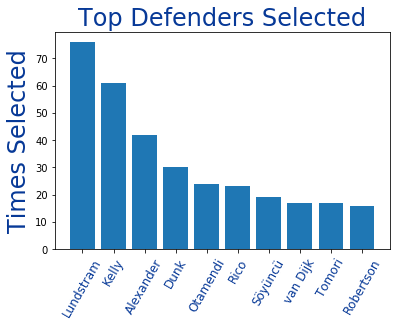

In [35]:
X = [item[0] for item in DF_top10]
Y = [item[1] for item in DF_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Defenders Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

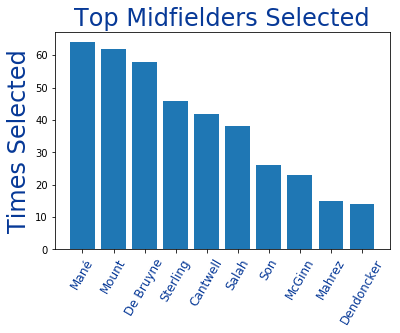

In [36]:
X = [item[0] for item in MD_top10]
Y = [item[1] for item in MD_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Midfielders Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

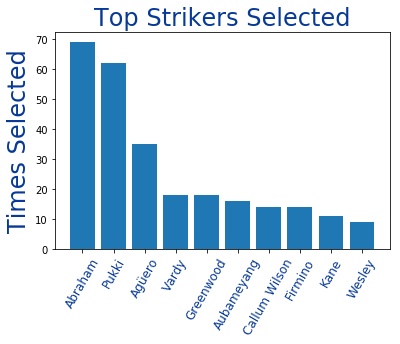

In [37]:
X = [item[0] for item in ST_top10]
Y = [item[1] for item in ST_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Strikers Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show

In [38]:
top_managers_team = GK_top10[:2]+ DF_top10[:5] + MD_top10[:5] + ST_top10[:3]

In [39]:
top_managers_team

[('Button', 38),
 ('Pope', 37),
 ('Lundstram', 76),
 ('Kelly', 61),
 ('Alexander', 42),
 ('Dunk', 30),
 ('Otamendi', 24),
 ('Mané', 64),
 ('Mount', 62),
 ('De Bruyne', 58),
 ('Sterling', 46),
 ('Cantwell', 42),
 ('Abraham', 69),
 ('Pukki', 62),
 ('Agüero', 35)]

<function matplotlib.pyplot.show(*args, **kw)>

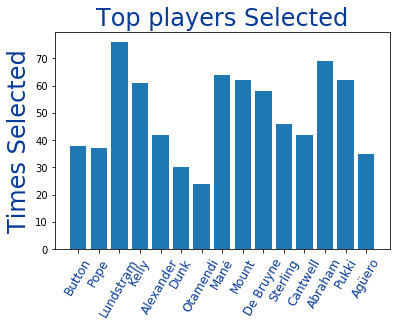

In [40]:
X = [item[0] for item in top_managers_team]
Y = [item[1] for item in top_managers_team]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top players Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show

### Latest Injury Updates from independant site that updates faster than the Fantasy site

In [55]:
injuries = 'http://www.premierinjuries.com/?fbclid=IwAR1Uz0TTwRMOvsq1jlefIztPPg7qtPdnag3zrHxh_39wV4CZoMG0ZWq6MYU'
injuries_tab = pd.read_html(injuries)[0]

In [56]:
injuries_tab

Player                   Reason
0       Thomas Heaton                    Other
1      Ilkay Gundogan                    Other
2     Oliver McBurnie                    Other
3  Morgan Gibbs-White        Lower Back Injury
4     Mason Greenwood        Lower Back Injury
5        Reiss Nelson              Knee Injury
6        Fabian Delph             Thigh Injury
7         Jamal Lewis              Knee Injury
8    Pedro Lomba Neto    Calf/Shin/Heel Injury
9         Ben Godfrey  Groin/Hip/Pelvic Injury

In [43]:
top100_users.head()

rank  user_id_num  total_points  game_week_points  \
users                                                                      
nick tanner               1       568651           587                65   
Boyko Iliev               2       191908           578                57   
Kittipong Kaewsopon       3       406431           573                59   
Raushan Uttamchandani     4      1229681           569                54   
david croley              4      1966144           569                43   

                                                      formation  \
users                                                             
nick tanner            {'GKP': 1, 'DEF': 3, 'MID': 5, 'FWD': 2}   
Boyko Iliev            {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   
Kittipong Kaewsopon    {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   
Raushan Uttamchandani  {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   
david croley           {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   

                                  GKP_1               GKP_2  \
users                                                         
nick tanner              Ryan-BHA-start    McGovern-NOR-sub   
Boyko Iliev              Pope-BUR-start    Patrício-WOL-sub   
Kittipong Kaewsopon      Ryan-BHA-start  Schmeichel-LEI-sub   
Raushan Uttamchandani    Ryan-BHA-start    McGovern-NOR-sub   
david croley           Heaton-AVL-start        Ryan-BHA-sub   

                                            DEF_1                DEF_2  \
users                                                                    
nick tanner                       Kelly-CRY-start       Dunk-BHA-start   
Boyko Iliev            Alexander-Arnold-LIV-start  O'Connell-SHU-start   
Kittipong Kaewsopon            van Dijk-LIV-start    Coleman-EVE-start   
Raushan Uttamchandani            Tomori-CHE-start    Pieters-BUR-start   
david croley                      Mings-AVL-start   Otamendi-MCI-start   

                                     DEF_3  ...            DEF_5  \
users                                       ...                    
nick tanner            Lundstram-SHU-start  ...     Rico-BOU-sub   
Boyko Iliev                  Mee-BUR-start  ...     Boly-WOL-sub   
Kittipong Kaewsopon        Kelly-CRY-start  ...  Söyüncü-LEI-sub   
Raushan Uttamchandani   Otamendi-MCI-start  ...    Kelly-CRY-sub   
david croley           Robertson-LIV-start  ...     Dunk-BHA-sub   

                                    MID_1                 MID_2  \
users                                                             
nick tanner            Sterling-MCI-start        Mané-LIV-start   
Boyko Iliev               Mount-CHE-start  Yarmolenko-WHU-start   
Kittipong Kaewsopon       Mount-CHE-start        Pépé-ARS-start   
Raushan Uttamchandani  Sterling-MCI-start    Cantwell-NOR-start   
david croley              Mount-CHE-start        Mané-LIV-start   

                                    MID_3                  MID_4  \
users                                                              
nick tanner               Mount-CHE-start        Salah-LIV-start   
Boyko Iliev                Mané-LIV-start     Cantwell-NOR-start   
Kittipong Kaewsopon        Mané-LIV-start  David Silva-MCI-start   
Raushan Uttamchandani      Mané-LIV-start          Son-TOT-start   
david croley           Cantwell-NOR-start       McGinn-AVL-start   

                                      MID_5              FWD_1  \
users                                                            
nick tanner              Cantwell-NOR-start  Abraham-CHE-start   
Boyko Iliev               De Bruyne-MCI-sub    Pukki-NOR-start   
Kittipong Kaewsopon    Harry Wilson-BOU-sub    Pukki-NOR-start   
Raushan Uttamchandani     De Bruyne-MCI-sub  Abraham-CHE-start   
david croley              De Bruyne-MCI-sub    Pukki-NOR-start   

                                   FWD_2                    FWD_3  \
users                                                               
nick tanner              Pukki-NOR

In [45]:
test = top100_users.formation

### Extract formations as a list in a readable format

In [46]:
formations = [item.split(",")[1][8] + "-" + item.split(",")[2][8] + "-" + item.split(",")[3][8] for item in test]

In [47]:
formations[:5]

['3-5-2', '3-4-3', '3-4-3', '3-4-3', '3-4-3']

### Use top_n function to get a tuple of ranked formations by count

In [51]:
top_form = return_top_n(formations, 6)

In [52]:
top_form

[('3-4-3', 52),
 ('4-3-3', 18),
 ('4-4-2', 14),
 ('3-5-2', 12),
 ('5-2-3', 2),
 ('5-3-2', 2)]

<function matplotlib.pyplot.show(*args, **kw)>

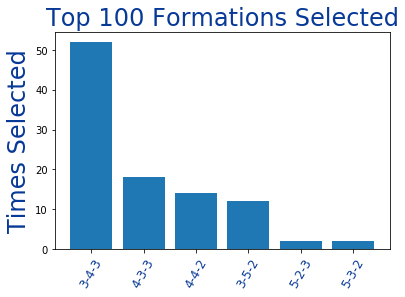

In [54]:
X = [item[0] for item in top_form]
Y = [item[1] for item in top_form]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 100 Formations Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show